In [174]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
import tensorflow.keras
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from ast import literal_eval
from gensim.models import CoherenceModel
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import timeit
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import ClassifierChain
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

In [175]:
data = pd.read_csv("Query_results_2011_2020_cleaned.csv",
                   index_col='Id', converters={'Text': literal_eval, 'Tags': literal_eval})

In [176]:
data.head()

Text  \
Id                                                           
5004633  [file, dot, prefix, windows, example, htaccess...   
5004344  [prevent, opera, browser, html, fieldsi, load,...   
5004908  [format, image, file, image, format, image, fi...   
5004837  [class, static, method, class, variable, pytho...   
5005409  [exception, resolve, assemblies, executable, f...   

                               Tags  
Id                                   
5004633                   [windows]  
5004344  [javascript, jquery, html]  
5004908                        [c#]  
5004837                    [python]  
5005409                        [c#]

In [177]:
data.shape

(85103, 2)

# Modèle non supervisés: LDA 

## Création du dictionnaire et du modèle LDA

In [178]:
X = data['Text']
print(X)

Id
5004633     [file, dot, prefix, windows, example, htaccess...
5004344     [prevent, opera, browser, html, fieldsi, load,...
5004908     [format, image, file, image, format, image, fi...
5004837     [class, static, method, class, variable, pytho...
5005409     [exception, resolve, assemblies, executable, f...
                                  ...                        
65505481    [data, pointer, std, vector, array, char, sour...
65507374    [geopandas, plotlyi, geopandas, region, name, ...
65506519    [modulo, operator, implementation, operator, c...
65524512    [git, message, branch, namei, microsoft, branc...
65524317    [char, array, string, c++, char, array, c++, c...
Name: Text, Length: 85103, dtype: object


In [179]:
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)

In [180]:
for word in X[5026197]:
    for key, value in id2word.items():
        if value == word:
            print(key, word, end=', ')

322 c++, 896 smart, 472 pointer, 404 implementations, 887 available, 889 comparisons, 474 pros, 469 con, 345 use, 897 spin, 888 collection, 31 answer, 437 lot, 352 comment, 472 pointer, 404 implementations, 120 post, 372 question, 404 implementations, 684 pointers, 322 c++, 474 pros, 469 con, 891 exceptions, 893 gotchas, 404 implementations, 31 answer, 898 understand, 890 differences, 895 similarities, 236 fact, 892 goal, 85 object, 735 libraries, 458 usage, 898 understand, 404 implementations, 345 use, 475 reference, 894 others, 

In [181]:
print(id2word.doc2bow(X[5026197]))
corpus = []
for text in X:
    new = id2word.doc2bow(text)
    corpus.append(new)

[(31, 2), (85, 1), (120, 1), (236, 1), (322, 2), (345, 2), (352, 1), (372, 1), (404, 5), (437, 1), (458, 1), (469, 2), (472, 2), (474, 2), (475, 1), (684, 1), (735, 1), (887, 1), (888, 1), (889, 1), (890, 1), (891, 1), (892, 1), (893, 1), (894, 1), (895, 1), (896, 1), (897, 1), (898, 2)]


In [182]:
LDA_model = gensim.models.ldamulticore\
    .LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  num_topics=20,
                  random_state=42,
                  per_word_topics=True,
                  workers=4)

## Evaluation et visualisation des resultats 

In [183]:
# Print Perplexity score
print('\nPerplexity: ', LDA_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=LDA_model, texts=X, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.686724005896464

Coherence Score:  0.4019441881418399


In [184]:
pyLDAvis.enable_notebook()
gensimvis.prepare(LDA_model, corpus, id2word, mds='mmds', R=30)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.202146  0.161130       1        1  8.382439
5      0.076128 -0.232488       2        1  7.910424
13    -0.153267  0.115281       3        1  7.681066
9     -0.237035  0.084694       4        1  7.551120
10     0.215403 -0.052077       5        1  6.615762
18    -0.047107 -0.082480       6        1  5.978235
1     -0.010140  0.234238       7        1  5.818375
7      0.009705 -0.147104       8        1  5.487263
4     -0.074082  0.149043       9        1  4.634230
11     0.070601 -0.079683      10        1  4.228725
2      0.119185  0.103904      11        1  4.205689
3      0.036535  0.060262      12        1  4.199276
6     -0.152810 -0.121799      13        1  4.089970
12     0.048749  0.150292      14        1  3.721950
16    -0.086829 -0.200690      15        1  3.710189
0     -0.017257  0.009472      16        1  3.581349
14    -0.100145 -0.022564      17        1  3.405407
15    -0.193106 -0.031880      18        1  3.262177
19     0.138239 -0.121643      19        1  2.979125
17     0.155087  0.024094      20        1  2.557229, topic_info=          Term          Freq         Total Category  logprob  loglift
843    android  24178.000000  24178.000000  Default  30.0000  30.0000
95      string  40201.000000  40201.000000  Default  29.0000  29.0000
1340       std  19896.000000  19896.000000  Default  28.0000  28.0000
40    function  47828.000000  47828.000000  Default  27.0000  27.0000
273        int  40513.000000  40513.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
441       test    590.756837  21634.766725  Topic20  -5.3284   0.0656
273        int    626.207415  40513.324887  Topic20  -5.2702  -0.5035
765       size    527.440315  13294.843989  Topic20  -5.4418   0.4392
36       class    554.512568  53389.532425  Topic20  -5.3917  -0.9010
35           c    539.271803  40578.208338  Topic20  -5.4196  -0.6545

[1841 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1365      1  0.028107         +id
1365      2  0.000907         +id
1365      3  0.000907         +id
1365      4  0.006347         +id
1365      5  0.002720         +id
...     ...       ...         ...
873      15  0.005766  zygoteinit
873      16  0.024986  zygoteinit
873      17  0.001922  zygoteinit
873      19  0.001922  zygoteinit
873      20  0.034596  zygoteinit

[12368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 14, 10, 11, 19, 2, 8, 5, 12, 3, 4, 7, 13, 17, 1, 15, 16, 20, 18])

## Optimisation du modèle 

In [185]:
coherence_test = []
for k in np.arange(1, 31, 1):
    print("Fitting LDA for K = {}".format(k))
    lda_model = gensim.models.ldamulticore\
        .LdaMulticore(corpus=corpus,
                      id2word=id2word,
                      num_topics=k,
                      random_state=8,
                      per_word_topics=True,
                      workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=X,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_test.append([k, coherence_lda])

Fitting LDA for K = 1
Fitting LDA for K = 2
Fitting LDA for K = 3
Fitting LDA for K = 4
Fitting LDA for K = 5
Fitting LDA for K = 6
Fitting LDA for K = 7
Fitting LDA for K = 8
Fitting LDA for K = 9
Fitting LDA for K = 10
Fitting LDA for K = 11
Fitting LDA for K = 12
Fitting LDA for K = 13
Fitting LDA for K = 14
Fitting LDA for K = 15
Fitting LDA for K = 16
Fitting LDA for K = 17
Fitting LDA for K = 18
Fitting LDA for K = 19
Fitting LDA for K = 20
Fitting LDA for K = 21
Fitting LDA for K = 22
Fitting LDA for K = 23
Fitting LDA for K = 24
Fitting LDA for K = 25
Fitting LDA for K = 26
Fitting LDA for K = 27
Fitting LDA for K = 28
Fitting LDA for K = 29
Fitting LDA for K = 30


Meilleur nombre de topics:22 , Coherence: 0.47


Text(0.5, 1.0, 'Meilleur nombre de topics')

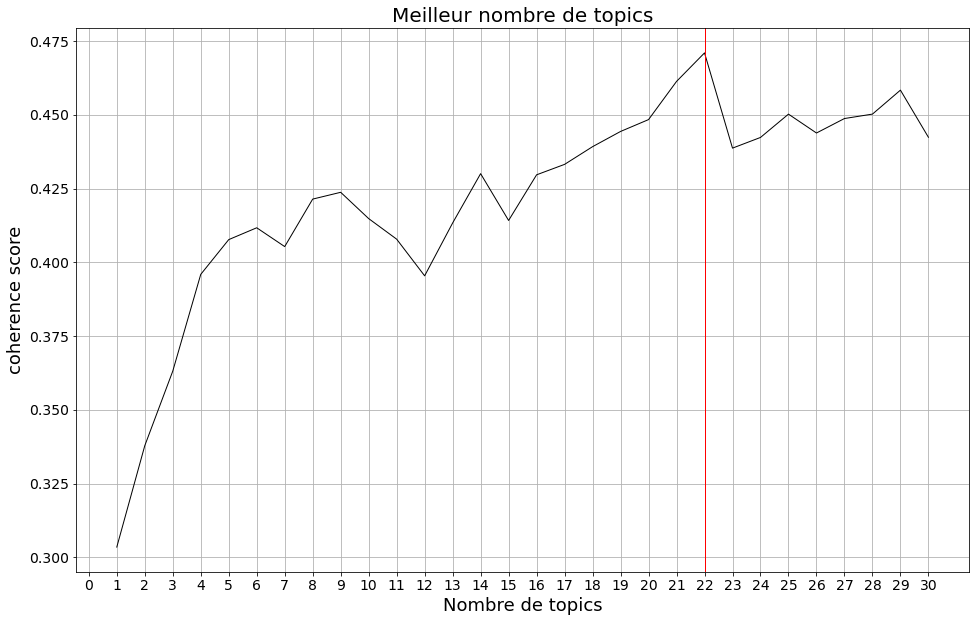

In [186]:
best_coherence = max([item[1] for item in coherence_test])
best_k = [item[0] for item in coherence_test if item[1] == best_coherence]
print('Meilleur nombre de topics:{} , Coherence: {}'.format(
    best_k[0], round(best_coherence, 2)))
fig = plt.figure(figsize=[16, 10])
plt.plot([item[0] for item in coherence_test], [item[1]
         for item in coherence_test], color='black', linewidth=1)
plt.xticks(np.arange(0, 31, 1), fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=best_k[0], color='red', linewidth=1)
plt.ylabel('coherence score', fontsize=18)
plt.xlabel('Nombre de topics', fontsize=18)
plt.grid()
plt.title('Meilleur nombre de topics', fontsize=20)

In [187]:
alpha = list(np.arange(0.01, 1, 0.3))
alpha = [round(elem, 2) for elem in alpha]
alpha.append('symmetric')
beta = list(np.arange(0.01, 1, 0.3))
beta = [round(elem, 2) for elem in beta]
beta.append('symmetric')
print('alpha: ', alpha)
print('beta: ', beta)

coherence_test = []
for a in alpha:
    for b in beta:
        print("Fitting LDA for alpha = {}, beta = {}".format(a, b))
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                            id2word=id2word,
                                                            num_topics=best_k[0],
                                                            random_state=42,
                                                            per_word_topics=True,
                                                            workers=4,
                                                            alpha=a,
                                                            eta=b)
        coherence_model_lda = CoherenceModel(model=lda_model,
                                             texts=X,
                                             dictionary=id2word,
                                             coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_test.append([best_k[0], a, b, round(coherence_lda, 3)])

alpha:  [0.01, 0.31, 0.61, 0.91, 'symmetric']
beta:  [0.01, 0.31, 0.61, 0.91, 'symmetric']
Fitting LDA for alpha = 0.01, beta = 0.01
Fitting LDA for alpha = 0.01, beta = 0.31
Fitting LDA for alpha = 0.01, beta = 0.61
Fitting LDA for alpha = 0.01, beta = 0.91
Fitting LDA for alpha = 0.01, beta = symmetric
Fitting LDA for alpha = 0.31, beta = 0.01
Fitting LDA for alpha = 0.31, beta = 0.31
Fitting LDA for alpha = 0.31, beta = 0.61
Fitting LDA for alpha = 0.31, beta = 0.91
Fitting LDA for alpha = 0.31, beta = symmetric
Fitting LDA for alpha = 0.61, beta = 0.01
Fitting LDA for alpha = 0.61, beta = 0.31
Fitting LDA for alpha = 0.61, beta = 0.61
Fitting LDA for alpha = 0.61, beta = 0.91
Fitting LDA for alpha = 0.61, beta = symmetric
Fitting LDA for alpha = 0.91, beta = 0.01
Fitting LDA for alpha = 0.91, beta = 0.31
Fitting LDA for alpha = 0.91, beta = 0.61
Fitting LDA for alpha = 0.91, beta = 0.91
Fitting LDA for alpha = 0.91, beta = symmetric
Fitting LDA for alpha = symmetric, beta = 0.01
Fi

In [188]:
coherence_df = pd.DataFrame(coherence_test, columns=[
                            'Topics', 'Alpha', 'Beta', 'Coherence'])
coherence_df = coherence_df.sort_values(
    by=['Coherence'], ascending=False).reset_index(drop=True)
coherence_df

Topics      Alpha       Beta  Coherence
0       22  symmetric       0.91      0.416
1       22       0.01       0.91      0.415
2       22       0.01       0.01      0.413
3       22       0.31       0.91      0.413
4       22       0.01       0.61      0.412
5       22       0.01  symmetric      0.411
6       22       0.31       0.31      0.411
7       22       0.31       0.61      0.411
8       22  symmetric       0.31      0.411
9       22       0.01       0.31      0.410
10      22  symmetric       0.61      0.410
11      22       0.61       0.91      0.410
12      22  symmetric  symmetric      0.410
13      22  symmetric       0.01      0.409
14      22       0.61       0.61      0.408
15      22       0.31  symmetric      0.406
16      22       0.31       0.01      0.406
17      22       0.61       0.31      0.403
18      22       0.61  symmetric      0.400
19      22       0.61       0.01      0.400
20      22       0.91       0.31      0.379
21      22       0.91  symmetric      0.378
22      22       0.91       0.01      0.376
23      22       0.91       0.61      0.376
24      22       0.91       0.91      0.371

In [189]:
LDA_model = gensim.models.ldamulticore\
    .LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  num_topics=best_k[0],
                  alpha=coherence_df.loc[0]['Alpha'],
                  eta=coherence_df.loc[0]['Beta'],
                  random_state=8,
                  per_word_topics=True,
                  workers=4)

In [190]:
# Print Perplexity score
print('\nPerplexity: ', round(LDA_model.log_perplexity(corpus), 2))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=LDA_model, texts=X, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', round(coherence_lda, 2))


Perplexity:  -7.24

Coherence Score:  0.47


In [191]:
gensimvis.prepare(LDA_model, corpus, id2word, mds='mmds', R=30)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.179461  0.072221       1        1  8.728150
13    -0.144807  0.132437       2        1  8.446857
18    -0.051246 -0.130352       3        1  7.356478
8     -0.121720 -0.084327       4        1  6.976981
15    -0.035810 -0.207362       5        1  5.650942
5      0.144159 -0.042642       6        1  5.629908
0      0.133220 -0.167877       7        1  5.243250
21     0.119800  0.166304       8        1  5.101662
1     -0.159678 -0.008417       9        1  5.093637
16    -0.049692  0.183848      10        1  4.543646
17     0.073020  0.159174      11        1  4.411978
11     0.118113  0.073319      12        1  4.268917
19     0.005526 -0.128167      13        1  3.902795
4      0.072756  0.003022      14        1  3.683809
6      0.091178 -0.124874      15        1  3.604134
20    -0.023893  0.055269      16        1  3.097632
10     0.018153 -0.066182      17        1  2.937596
12     0.201746  0.026829      18        1  2.773714
9      0.035038  0.057922      19        1  2.404280
3     -0.048033 -0.040992      20        1  2.065612
14    -0.086363  0.086905      21        1  2.057549
7     -0.112005 -0.016057      22        1  2.020473, topic_info=        Term          Freq         Total Category  logprob  loglift
843  android  21506.000000  21506.000000  Default  30.0000  30.0000
501     java  22107.000000  22107.000000  Default  29.0000  29.0000
35         c  33472.000000  33472.000000  Default  28.0000  28.0000
2       file  44753.000000  44753.000000  Default  27.0000  27.0000
273      int  36719.000000  36719.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
273      int    556.958193  36719.328052  Topic22  -5.1517  -0.2867
1    example    467.154869  18341.599726  Topic22  -5.3276   0.2316
45    method    442.628721  17455.271390  Topic22  -5.3815   0.2272
235    error    440.040365  38493.111954  Topic22  -5.3874  -0.5695
501     java    405.912522  22107.244350  Topic22  -5.4681  -0.0957

[1591 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1365      1  0.000870         +id
1365      2  0.002611         +id
1365      3  0.007834         +id
1365      4  0.000870         +id
1365      5  0.894779         +id
...     ...       ...         ...
873      18  0.002210  zygoteinit
873      19  0.013262  zygoteinit
873      20  0.006631  zygoteinit
873      21  0.002210  zygoteinit
873      22  0.013262  zygoteinit

[25168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 14, 19, 9, 16, 6, 1, 22, 2, 17, 18, 12, 20, 5, 7, 21, 11, 13, 10, 4, 15, 8])

In [192]:
# On calcule la matrice ‘documents-versus-topics’
doc_topic_df = pd.DataFrame(LDA_model.get_document_topics(
    corpus, minimum_probability=0)).set_index(data.index)

In [193]:
doc_topic_df.columns = ['Topic ' + str(i) for i in range(1, best_k[0]+1, 1)]

In [194]:
doc_topic_df.head(3)

Topic 1            Topic 2            Topic 3  \
Id                                                                 
5004633  (0, 0.0030325558)  (1, 0.0030325558)  (2, 0.0030325558)   
5004344  (0, 0.0014212258)  (1, 0.0014212258)  (2, 0.0014212258)   
5004908    (0, 0.22104555)  (1, 0.0041328208)  (2, 0.0041328208)   

                   Topic 4            Topic 5            Topic 6  \
Id                                                                 
5004633  (3, 0.0030325558)  (4, 0.0030325558)  (5, 0.0030325558)   
5004344  (3, 0.0014212258)  (4, 0.0014212258)  (5, 0.0014212258)   
5004908  (3, 0.0041328208)  (4, 0.0041328208)  (5, 0.0041328208)   

                   Topic 7            Topic 8            Topic 9  \
Id                                                                 
5004633  (6, 0.0030325558)  (7, 0.0030325558)  (8, 0.0030325558)   
5004344     (6, 0.9701542)  (7, 0.0014212258)  (8, 0.0014212258)   
5004908  (6, 0.0041328208)  (7, 0.0041328208)  (8, 0.0041328208)   

                  Topic 10  ...            Topic 13            Topic 14  \
Id                          ...                                           
5004633  (9, 0.0030325558)  ...  (12, 0.0030325558)  (13, 0.0030325558)   
5004344  (9, 0.0014212258)  ...  (12, 0.0014212258)  (13, 0.0014212258)   
5004908  (9, 0.0041328208)  ...  (12, 0.0041328208)  (13, 0.0041328208)   

                   Topic 15            Topic 16            Topic 17  \
Id                                                                    
5004633  (14, 0.0030325558)  (15, 0.0030325558)  (16, 0.0030325558)   
5004344  (14, 0.0014212258)  (15, 0.0014212258)  (16, 0.0014212258)   
5004908  (14, 0.0041328208)  (15, 0.0041328208)  (16, 0.0041328208)   

                   Topic 18            Topic 19            Topic 20  \
Id                                                                    
5004633  (17, 0.0030325558)  (18, 0.0030325558)  (19, 0.0030325558)   
5004344  (17, 0.0014212258)  (18, 0.0014212258)  (19, 0.0014212258)   
5004908  (17, 0.0041328208)  (18, 0.0041328208)  (19, 0.0041328208)   

                   Topic 21            Topic 22  
Id                                               
5004633  (20, 0.0030325558)  (21, 0.0030325558)  
5004344  (20, 0.0014212258)  (21, 0.0014212258)  
5004908  (20, 0.0041328208)  (21, 0.0041328208)  

[3 rows x 22 columns]

# Modèles supervisés:

## Approche TF-IDF pour la vectorisation du texte

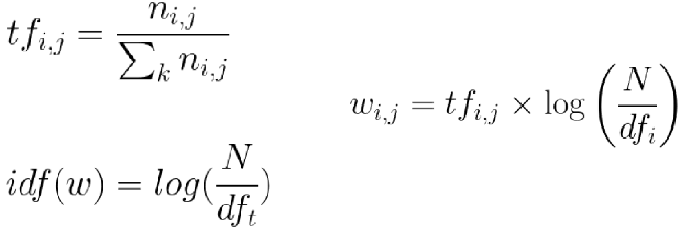

In [195]:
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=0.6,
                             min_df=0.01,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
# on apprend le vocabulaire et idf du training set data['Text']. Ensuite on obtient la matrice document-word
X_tfidf = vectorizer.fit_transform(data['Text'])
cols = vectorizer.get_feature_names()
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=cols).round(3)
print(df_tfidf)

       access  account  action  activity  add  address  advance  alert  \
0         0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
1         0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
2         0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
3         0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
4         0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
...       ...      ...     ...       ...  ...      ...      ...    ...   
85098     0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
85099     0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
85100     0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
85101     0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   
85102     0.0      0.0     0.0       0.0  0.0      0.0      0.0    0.0   

       algorithm  amount  ...  window  windows  word   work  workaround  \
0            0.0   0.000  ...     0.

In [196]:
full_dense = X_tfidf.todense()
print("Text sparsicity: {:.3f} %"
      .format(((full_dense > 0).sum()/full_dense.size)*100))

Text sparsicity: 3.388 %


## Modèle avec Logistic regression

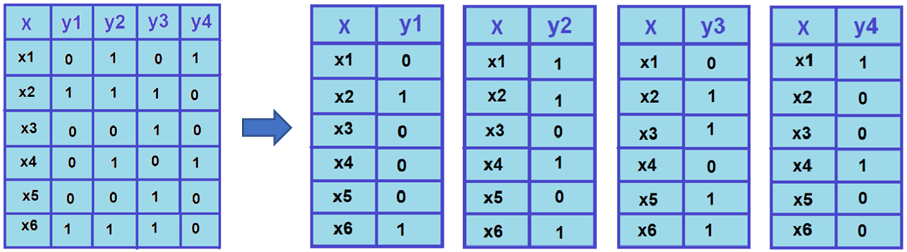

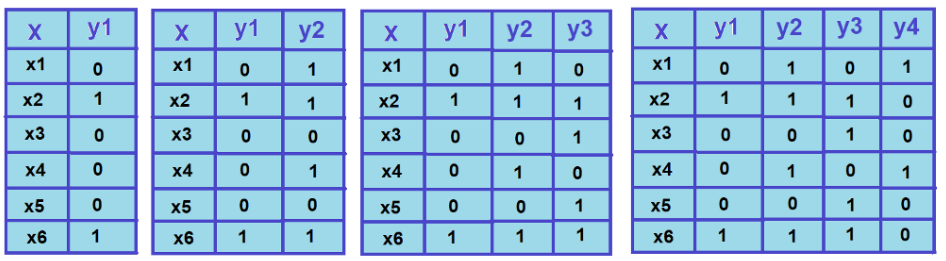

In [197]:
X = X_tfidf
print('Dimensions de X: ', X.shape)

Dimensions de X:  (85103, 523)


In [198]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data['Tags'])
multilabel_binarizer.classes_
y = multilabel_binarizer.transform(data['Tags'])
y.shape

(85103, 50)

In [199]:
y_df = pd.DataFrame(data=y, columns=multilabel_binarizer.classes_)
y_df

.net  algorithm  android  angular  angularjs  arrays  asp.net  \
0         0          0        0        0          0       0        0   
1         0          0        0        0          0       0        0   
2         0          0        0        0          0       0        0   
3         0          0        0        0          0       0        0   
4         0          0        0        0          0       0        0   
...     ...        ...      ...      ...        ...     ...      ...   
85098     0          0        0        0          0       0        0   
85099     0          0        0        0          0       0        0   
85100     0          0        0        0          0       0        0   
85101     0          0        0        0          0       0        0   
85102     0          0        0        0          0       0        0   

       asp.net-mvc  c  c#  ...  ruby  ruby-on-rails  sql  sql-server  string  \
0                0  0   0  ...     0              0    0           0       0   
1                0  0   0  ...     0              0    0           0       0   
2                0  0   1  ...     0              0    0           0       0   
3                0  0   0  ...     0              0    0           0       0   
4                0  0   1  ...     0              0    0           0       0   
...            ... ..  ..  ...   ...            ...  ...         ...     ...   
85098            0  0   0  ...     0              0    0           0       0   
85099            0  0   0  ...     0              0    0           0       0   
85100            0  1   0  ...     0              0    0           0       0   
85101            0  0   0  ...     0              0    0           0       0   
85102            0  0   0  ...     0              0    0           0       0   

       swift  typescript  visual-studio  windows  xcode  
0          0           0              0        1      0  
1          0           0              0        0      0  
2          0           0              0        0      0  
3          0           0              0        0      0  
4          0           0              0        0      0  
...      ...         ...            ...      ...    ...  
85098      0           0              0        0      0  
85099      0           0              0        0      0  
85100      0           0              0        0      0  
85101      0           0              0        0      0  
85102      0           0              0        0      0  

[85103 rows x 50 columns]

In [200]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)
print("X_train dimension: ", X_train.shape)
print("y_train dimension: ", y_train.shape)
print("X_test dimension: ", X_test.shape)
print("y_test dimension: ", y_test.shape)

X_train dimension:  (68082, 523)
y_train dimension:  (68082, 50)
X_test dimension:  (17021, 523)
y_test dimension:  (17021, 50)


### Baseline model

In [201]:
score_df = pd.DataFrame(
    columns=['Accuracy', 'Precision', 'Recall', 'F1-measure', 'Jaccard'])


def models_scores(y_true, y_pred):
    scores = []
    scores.append(metrics.accuracy_score(y_true, y_pred))
    scores.append(metrics.precision_score(y_true, y_pred, average='weighted'))
    scores.append(metrics.recall_score(y_true, y_pred, average='weighted'))
    scores.append(metrics.f1_score(y_true, y_pred, average='weighted'))
    scores.append(metrics.jaccard_score(y_true, y_pred, average='weighted'))
    return scores

### Approche Binary Relevance pour la classification multilabel

In [202]:
start_time = timeit.default_timer()
log_reg_BR_clf = BinaryRelevance(LogisticRegression())
log_reg_BR_clf.fit(X_train, y_train)
predictions = log_reg_BR_clf.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 69.73737s


In [203]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [(), (), ('python',), ('asp.net-mvc',), ('sql', 'sql-server'), ('algorithm',), (), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [204]:
models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.332
Precision : 0.784
Recall : 0.463
F1 : 0.568
Jaccard : 0.423


### Approche Classifier Chains pour la classification multilabel

In [205]:
start_time = timeit.default_timer()
log_reg_CC_clf = ClassifierChain(LogisticRegression())
log_reg_CC_clf.fit(X_train, y_train)
predictions = log_reg_CC_clf.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 82.70432s


In [206]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [(), (), ('python',), ('asp.net-mvc',), ('sql', 'sql-server'), ('algorithm',), ('r',), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [207]:
models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.378
Precision : 0.74
Recall : 0.508
F1 : 0.584
Jaccard : 0.438


### Optimisation des hyperparamètres avec validation croisée

In [208]:
param_grid = {
    "classifier__C": [1000, 100, 10],
}

base_estimator = ClassifierChain(LogisticRegression())

log_reg_cv_clf = GridSearchCV(base_estimator, param_grid, cv=2,
                              scoring="f1_weighted", return_train_score=True, refit=True, verbose=5)
start_time = timeit.default_timer()
log_reg_cv_clf = log_reg_cv_clf.fit(X_train, y_train)
predictions = log_reg_cv_clf.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))
print("Best parameters: ", log_reg_cv_clf.best_params_)
print("Best Cross Validation Score: ", round(log_reg_cv_clf.best_score_, 2))

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END classifier__C=1000;, score=(train=0.662, test=0.580) total time=  59.4s
[CV 2/2] END classifier__C=1000;, score=(train=0.661, test=0.580) total time=  58.2s
[CV 1/2] END classifier__C=100;, score=(train=0.660, test=0.587) total time=  58.4s
[CV 2/2] END classifier__C=100;, score=(train=0.659, test=0.585) total time=  58.3s
[CV 1/2] END classifier__C=10;, score=(train=0.643, test=0.590) total time=  57.1s
[CV 2/2] END classifier__C=10;, score=(train=0.643, test=0.589) total time=  56.6s
Temps entrainement: 480.56484s
Best parameters:  {'classifier__C': 10}
Best Cross Validation Score:  0.59


In [209]:
start_time = timeit.default_timer()
log_reg_clf = ClassifierChain(LogisticRegression(
    C=10, penalty='l2', solver='liblinear'))
log_reg_clf.fit(X_train, y_train)
predictions = log_reg_clf.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 34.55735s


In [210]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [(), ('java',), ('python',), ('asp.net-mvc',), ('sql', 'sql-server'), ('algorithm',), ('r',), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [211]:
log_reg = models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.396
Precision : 0.707
Recall : 0.543
F1 : 0.601
Jaccard : 0.452


In [212]:
scores = {}
scores['logistic_regression'] = log_reg

pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

logistic_regression
Accuracy              0.395805
Precision             0.707282
Recall                0.543127
F1                    0.600933
Jaccard               0.452441

## Modèle avec Random Forest 

### Baseline model 

In [213]:
start_time = timeit.default_timer()
classifier1 = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
classifier1.fit(X_train, y_train)
predictions = classifier1.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 196.23972s


In [214]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [('mysql',), (), ('python',), (), ('sql',), ('algorithm', 'python'), (), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [215]:
models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.336
Precision : 0.799
Recall : 0.428
F1 : 0.522
Jaccard : 0.399


### Optimisation des hyperparamètres avec validation croisée 

In [216]:
param_grid = {
    "estimator__n_estimators": [90, 100, 115, 130],
    "estimator__min_samples_split": [2, 5, 8, 10]
}

base_estimator = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
clf = GridSearchCV(base_estimator, param_grid, cv=2, scoring="f1_weighted",
                   return_train_score=True, refit=True, verbose=5)
start_time = timeit.default_timer()
clf.fit(X_train[0:10000], y_train[0:10000])
predictions = clf.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))
print("Best parameters: ", clf.best_params_)
print("Best Cross Validation Score: ", clf.best_score_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END estimator__min_samples_split=2, estimator__n_estimators=90;, score=(train=0.999, test=0.400) total time=   5.9s
[CV 2/2] END estimator__min_samples_split=2, estimator__n_estimators=90;, score=(train=1.000, test=0.393) total time=   5.9s
[CV 1/2] END estimator__min_samples_split=2, estimator__n_estimators=100;, score=(train=1.000, test=0.406) total time=   6.5s
[CV 2/2] END estimator__min_samples_split=2, estimator__n_estimators=100;, score=(train=0.999, test=0.396) total time=   6.5s
[CV 1/2] END estimator__min_samples_split=2, estimator__n_estimators=115;, score=(train=1.000, test=0.410) total time=   7.4s
[CV 2/2] END estimator__min_samples_split=2, estimator__n_estimators=115;, score=(train=1.000, test=0.403) total time=   7.5s
[CV 1/2] END estimator__min_samples_split=2, estimator__n_estimators=130;, score=(train=1.000, test=0.407) total time=   8.3s
[CV 2/2] END estimator__min_samples_split=2, estimator__n_e

### Modèle avec hyperparamètres optimisés

In [217]:
start_time = timeit.default_timer()
classifier1 = OneVsRestClassifier(RandomForestClassifier(n_estimators=115,
                                                         min_samples_split=2), n_jobs=-1)
classifier1.fit(X_train, y_train)
predictions = classifier1.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 229.00380s


In [218]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [('mysql',), (), ('python',), (), ('sql',), ('python',), (), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [219]:
rnd_for = models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.335
Precision : 0.799
Recall : 0.43
F1 : 0.523
Jaccard : 0.4


In [220]:
scores['random_forest'] = rnd_for
pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

logistic_regression  random_forest
Accuracy              0.395805       0.335292
Precision             0.707282       0.799119
Recall                0.543127       0.429897
F1                    0.600933       0.523460
Jaccard               0.452441       0.399928

## Modèle avec SVC

### Baseline model 

In [221]:
from sklearn.svm import LinearSVC

start_time = timeit.default_timer()
svm_classifier = ClassifierChain(LinearSVC())
svm_classifier.fit(X_train, y_train)
predictions = svm_classifier.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 23.93779s


In [222]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [(), (), ('python',), ('asp.net-mvc',), ('sql', 'sql-server'), ('algorithm',), ('r',), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [223]:
models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.386
Precision : 0.729
Recall : 0.515
F1 : 0.582
Jaccard : 0.437


### Optimisation des hyperparamètres avec validation croisée 

In [224]:
param_grid = {
    "classifier__C": [100, 10, 1, 0.1],
    "classifier__loss": ['hinge', 'squared_hinge'],
    "classifier__dual": [False]
}

base_estimator = ClassifierChain(LinearSVC())

print(base_estimator.get_params().keys())

svm_classifier = GridSearchCV(base_estimator, param_grid, cv=2,
                              scoring="f1_weighted", return_train_score=True, refit=True, verbose=5)
start_time = timeit.default_timer()
svm_classifier.fit(X_train, y_train)
predictions = svm_classifier.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))
print("Best parameters: ", svm_classifier.best_params_)
print("Best Cross Validation Score: ", svm_classifier.best_score_)

dict_keys(['classifier', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__loss', 'classifier__max_iter', 'classifier__multi_class', 'classifier__penalty', 'classifier__random_state', 'classifier__tol', 'classifier__verbose', 'require_dense', 'order'])
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END classifier__C=100, classifier__dual=False, classifier__loss=hinge;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/2] END classifier__C=100, classifier__dual=False, classifier__loss=hinge;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/2] END classifier__C=100, classifier__dual=False, classifier__loss=squared_hinge;, score=(train=0.642, test=0.571) total time=  18.8s
[CV 2/2] END classifier__C=100, classifier__dual=False, classifier__loss=squared_hinge;, score=(train=0.641, test=0.570) total time=  18.1s
[CV 1/2] END classifier__C=10, classifier__dual=False, classi

### Modèle avec hyperparamètres optimisés

In [225]:
start_time = timeit.default_timer()
classifier1 = ClassifierChain(LinearSVC(C=10, loss='squared_hinge', dual=False))
classifier1.fit(X_train, y_train)
predictions = classifier1.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 27.13877s


In [226]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [(), (), ('python',), ('asp.net-mvc',), ('sql', 'sql-server'), ('algorithm',), ('r',), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [227]:
svc = models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.39
Precision : 0.722
Recall : 0.523
F1 : 0.585
Jaccard : 0.44


In [228]:
scores['svc'] = svc
pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

logistic_regression  random_forest       svc
Accuracy              0.395805       0.335292  0.389578
Precision             0.707282       0.799119  0.722331
Recall                0.543127       0.429897  0.523394
F1                    0.600933       0.523460  0.585412
Jaccard               0.452441       0.399928  0.439638

## Modèle avec SGD

### Baseline model 

In [229]:
from sklearn.linear_model import SGDClassifier

start_time = timeit.default_timer()
sgd_classifier = ClassifierChain(SGDClassifier())
sgd_classifier.fit(X_train, y_train)
predictions = sgd_classifier.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 28.83020s


In [230]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [(), (), ('python',), (), ('sql', 'sql-server'), ('algorithm',), ('r',), ('c',), (), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [231]:
sgd = models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.34
Precision : 0.691
Recall : 0.44
F1 : 0.509
Jaccard : 0.386


###  Optimisation des hyperparamètres avec validation croisée 

In [232]:
param_grid = {
    "classifier__alpha": [0.1, 0.01, 0.001, 0.0001],
    "classifier__learning_rate": ['adaptive', 'optimal'],
    "classifier__eta0": [0.01]
}

base_estimator = ClassifierChain(SGDClassifier())

print(base_estimator.get_params().keys())

sgd_classifier = GridSearchCV(base_estimator, param_grid, cv=2,
                              scoring="f1_weighted", return_train_score=True, refit=True, verbose=5)
start_time = timeit.default_timer()
sgd_classifier.fit(X_train, y_train)
predictions = sgd_classifier.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))
print("Best parameters: ", sgd_classifier.best_params_)
print("Best Cross Validation Score: ", sgd_classifier.best_score_)

dict_keys(['classifier', 'classifier__alpha', 'classifier__average', 'classifier__class_weight', 'classifier__early_stopping', 'classifier__epsilon', 'classifier__eta0', 'classifier__fit_intercept', 'classifier__l1_ratio', 'classifier__learning_rate', 'classifier__loss', 'classifier__max_iter', 'classifier__n_iter_no_change', 'classifier__n_jobs', 'classifier__penalty', 'classifier__power_t', 'classifier__random_state', 'classifier__shuffle', 'classifier__tol', 'classifier__validation_fraction', 'classifier__verbose', 'classifier__warm_start', 'require_dense', 'order'])
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END classifier__alpha=0.1, classifier__eta0=0.01, classifier__learning_rate=adaptive;, score=(train=0.000, test=0.000) total time=  48.8s
[CV 2/2] END classifier__alpha=0.1, classifier__eta0=0.01, classifier__learning_rate=adaptive;, score=(train=0.000, test=0.000) total time=  48.4s
[CV 1/2] END classifier__alpha=0.1, classifier__eta0=0.01, classifier

### Modèle avec hyperparamètres optimisés 

In [233]:
start_time = timeit.default_timer()
classifier1 = ClassifierChain(SGDClassifier(
    alpha=0.0001, eta0=0.01, learning_rate='optimal'))
classifier1.fit(X_train, y_train)
predictions = classifier1.predict(X_test)
elapsed_fit = timeit.default_timer() - start_time
print("Temps entrainement: {:.5f}s".format(elapsed_fit))

Temps entrainement: 30.34752s


In [234]:
predictions_inversed = multilabel_binarizer.inverse_transform(predictions)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)
print("Predicted:", predictions_inversed[0:10])
print("True:", y_test_inversed[0:10])

Predicted: [('mysql',), (), ('python',), (), ('sql', 'sql-server'), ('algorithm',), ('r',), ('c',), (), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [235]:
sgd = models_scores(y_test, predictions)
print("Accuracy :", round(models_scores(y_test, predictions)[0], 3))
print("Precision :", round(models_scores(y_test, predictions)[1], 3))
print("Recall :", round(models_scores(y_test, predictions)[2], 3))
print("F1 :", round(models_scores(y_test, predictions)[3], 3))
print("Jaccard :", round(models_scores(y_test, predictions)[4], 3))

Accuracy : 0.342
Precision : 0.696
Recall : 0.441
F1 : 0.516
Jaccard : 0.39


In [237]:
scores['sgd'] = sgd
pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

logistic_regression  random_forest       svc       sgd
Accuracy              0.395805       0.335292  0.389578  0.341696
Precision             0.707282       0.799119  0.722331  0.696023
Recall                0.543127       0.429897  0.523394  0.441447
F1                    0.600933       0.523460  0.585412  0.516034
Jaccard               0.452441       0.399928  0.439638  0.390182

## Approches word embeddings: Word2Vec 

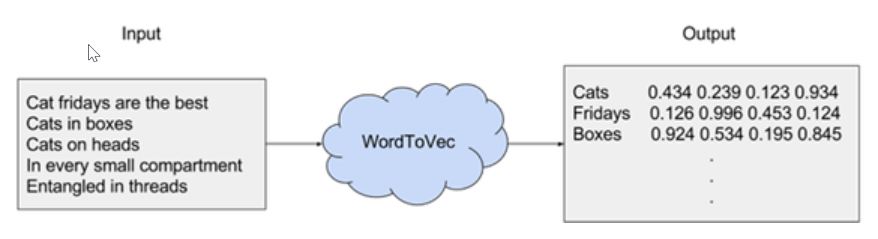

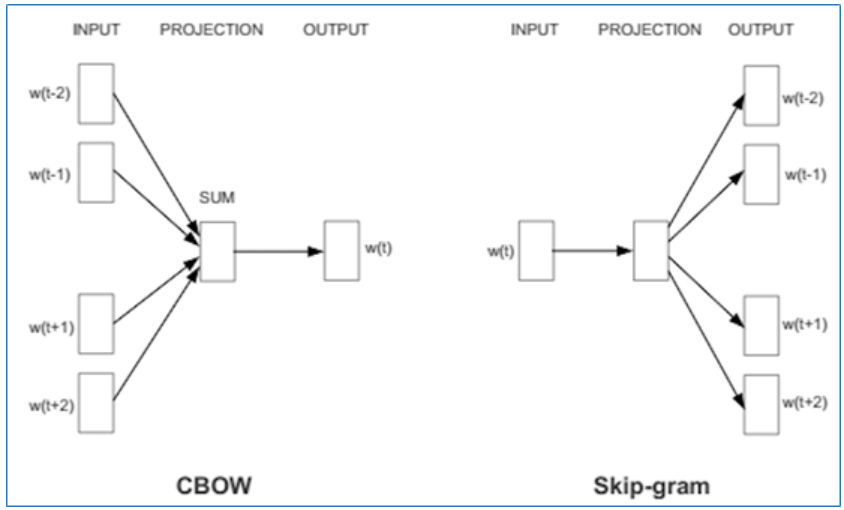

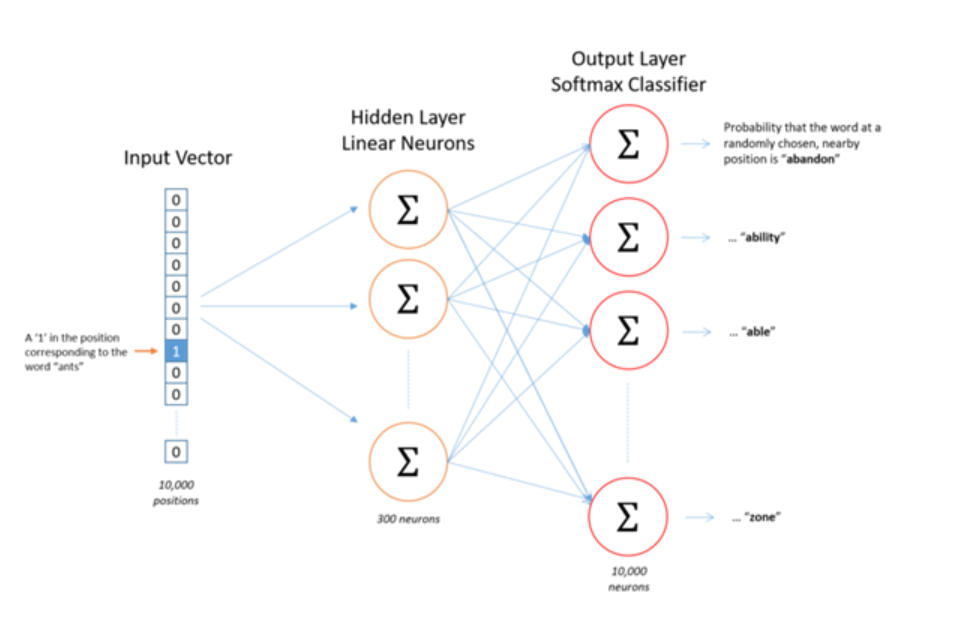

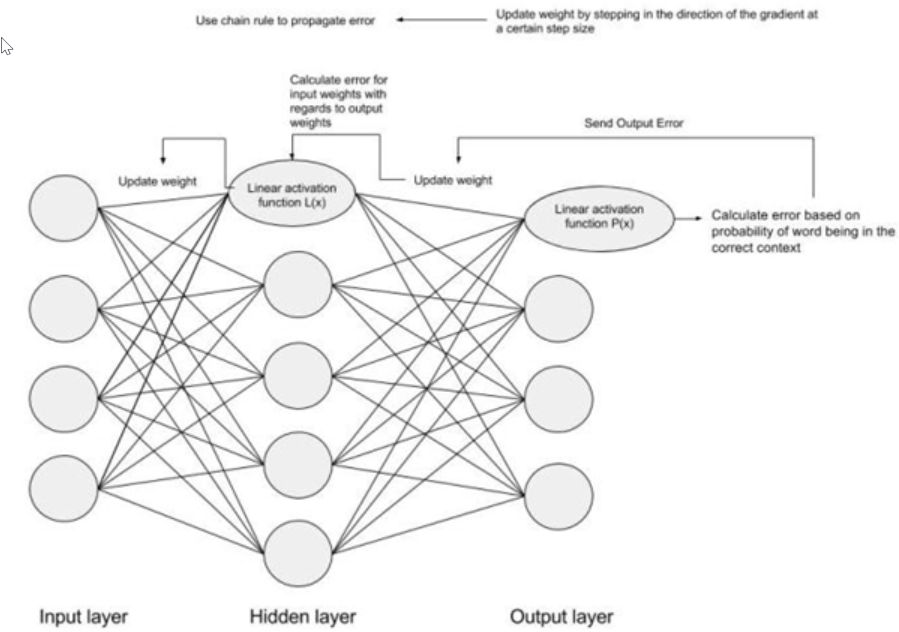

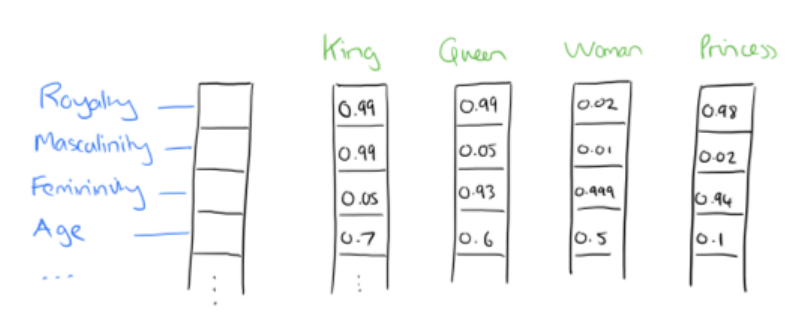

In [238]:
X = data['Text']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)
print("X_train dimension: ", X_train.shape)
print("y_train dimension: ", y_train.shape)
print("X_test dimension: ", X_test.shape)
print("y_test dimension: ", y_test.shape)

X_train dimension:  (68082,)
y_train dimension:  (68082, 50)
X_test dimension:  (17021,)
y_test dimension:  (17021, 50)


### Création du modèle Word2Vec

In [239]:
lst_corpus = X_train.values
# on trouve la longueur maximale des documents du corpus (Text)
max_len = 0
t = 0
for i in lst_corpus:
    t += 1
    if len(i) > max_len:
        max_len = len(i)
        max_ind = t
print('Index document max longuer: ', max_ind)
print('Max longuer documents :', max_len)
print(lst_corpus[60401])

Index document max longuer:  64574
Max longuer documents : 433
['self', 'c', 'code', 'size', 'feature', 'code', 'footprint', 'dependencies', 'unicode', 'string', 'support', 'code', 'c', 'code', 'c++', 'c', 'java', 'syntax', 'operators', 'bitwise', 'thread', 'support', 'generic', 'bytecode', 'bytecode', 'machine', 'architecture', 'barebones', 'language', 'support', 'lexer', 'parser', 'compiler', 'program', 'bytecode', 'lua', 'squirrel', 'neko', 'pawn', 'angelscript', 'spec', 'lua', 'syntax', 'bitwise', 'support', 'code', 'style', 'squirrel', 'pawn', 'bytecode', 'platform', 'implementation', 'issue', 'bytecode', 'headers', 'afaik', 'option', 'thank', 'update', 'javascript', 'interpreters', 'interpreters', 'question', 'bytecode', 'compiler', 'bytecode', 'separation', 'requirement', 'jit', 'jit', 'ecmascript', 'parsers']


In [240]:
w2v_size = 100
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = max_len

In [241]:
# Création et entraînement du modèle Word2Vec
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
# Création du vocabulaire
w2v_model.build_vocab(lst_corpus)

# Training du modèle
w2v_model.train(
    lst_corpus, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)

model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 154268
Word2Vec trained


In [242]:
w2v_model.wv['windows']

array([ 1.5079176 ,  0.40898186,  0.67074364, -2.221485  ,  1.6103606 ,  1.6093676 , -0.41453567, -0.88629574, -1.428289  ,  0.5575228 ,
        2.4943812 , -0.8380381 , -2.8726003 , -1.4473621 ,  0.682184  , -0.50205505, -1.4901547 ,  4.97938   ,  0.26542276, -0.6456033 ,
       -2.5806458 ,  0.06252164,  1.2262489 , -3.7655442 , -1.1396327 , -1.209292  ,  0.7032776 , -0.970506  , -1.5647858 ,  0.75640863,
        0.25800678,  0.19180842, -0.27922145, -0.7699596 ,  2.0247552 , -0.65514964, -0.10147111, -0.49802017, -1.0534004 , -1.5657892 ,
        1.305437  ,  1.4966626 , -2.284674  , -1.2852193 , -1.0544275 , -2.167934  , -1.9565452 , -2.0037854 , -0.6103046 ,  4.028882  ,
        1.4606727 ,  3.816831  ,  0.27360207, -0.24429561, -0.2594015 ,  1.3913887 ,  1.4979129 , -2.1611059 , -0.3387252 , -1.6216093 ,
       -0.38786414,  2.1697617 ,  0.25455615,  0.30432662,  0.294102  ,  1.8641273 , -0.423793  , -3.266927  ,  2.1316764 , -1.0049596 ,
       -0.13244009,  0.94471234, -1.06455

In [243]:
# trouver des mots similaires au mot donné
w2v_model.wv.most_similar('c++')

[('compiler', 0.715822160243988),
 ('standard', 0.7097752094268799),
 ('gcc', 0.7034124135971069),
 ('compilers', 0.690790593624115),
 ('c', 0.6841399669647217),
 ('program', 0.6805590391159058),
 ('c++i', 0.6628971099853516),
 ('g++', 0.6452218890190125),
 ('stl', 0.6333837509155273),
 ('pointers', 0.6230368614196777)]

### Feature engineering pour X_train 

In [244]:
# Tokenisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lst_corpus)

# Création sequence
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

print(lst_corpus[60401])
print(lst_text2seq[60401])

# Padding sequence
X_train = pad_sequences(lst_text2seq, maxlen=maxlen, padding='post')
np.set_printoptions(linewidth=140)
print(X_train[60401])
X_train.shape

['self', 'c', 'code', 'size', 'feature', 'code', 'footprint', 'dependencies', 'unicode', 'string', 'support', 'code', 'c', 'code', 'c++', 'c', 'java', 'syntax', 'operators', 'bitwise', 'thread', 'support', 'generic', 'bytecode', 'bytecode', 'machine', 'architecture', 'barebones', 'language', 'support', 'lexer', 'parser', 'compiler', 'program', 'bytecode', 'lua', 'squirrel', 'neko', 'pawn', 'angelscript', 'spec', 'lua', 'syntax', 'bitwise', 'support', 'code', 'style', 'squirrel', 'pawn', 'bytecode', 'platform', 'implementation', 'issue', 'bytecode', 'headers', 'afaik', 'option', 'thank', 'update', 'javascript', 'interpreters', 'interpreters', 'question', 'bytecode', 'compiler', 'bytecode', 'separation', 'requirement', 'jit', 'jit', 'ecmascript', 'parsers']
[71, 8, 1, 42, 280, 1, 3624, 401, 886, 5, 262, 1, 8, 1, 43, 8, 16, 361, 876, 1936, 44, 262, 1093, 2252, 2252, 247, 913, 35787, 279, 262, 4852, 759, 130, 48, 2252, 2668, 19414, 146379, 27734, 146380, 962, 2668, 361, 1936, 262, 1, 139, 

(68082, 433)

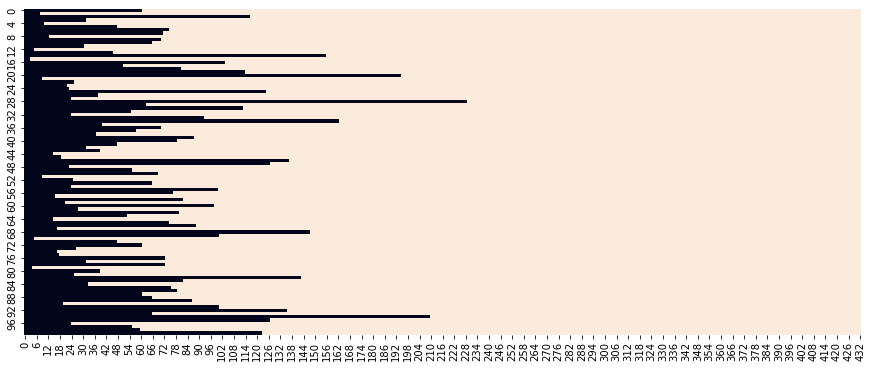

In [245]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(X_train[0:100] == 0, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

###  Feature engineering pour X_test 

In [246]:
lst_corpus = X_test.values

# Création sequence
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# Padding sequence
X_test = pad_sequences(lst_text2seq, maxlen=maxlen, padding='post')

X_test.shape

(17021, 433)

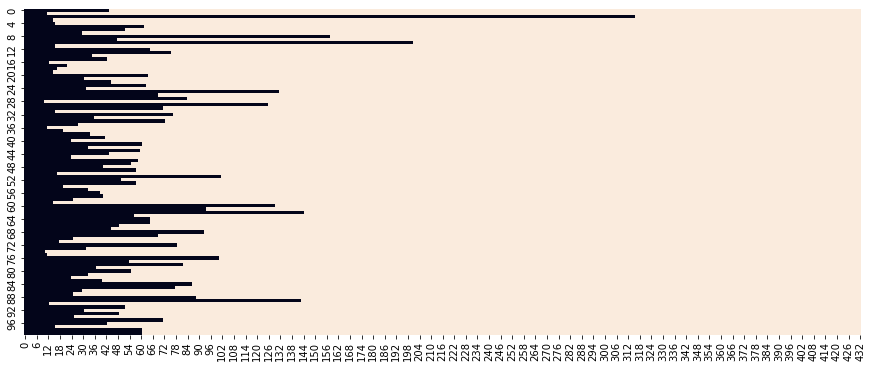

In [247]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(X_test[0:100] == 0, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

### Création de la matrice d'embedding 

In [248]:
print("Create Embedding matrix ...")
w2v_size = 100
word_index = tokenizer.word_index

vocab_size = len(word_index) + 1

embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

# on crée la matrice de mapping (look_up table) entre words hot-encoded et words vectors
for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)

print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (154269, 100)


In [249]:
embedding_matrix[1]

array([-0.26151097,  0.44483051,  0.60282624, -0.12312666,  0.27600241,  0.29149169, -1.88750362, -1.69212508,  0.8615247 ,  0.8134101 ,
        1.80794251, -0.57411104,  0.94044799, -2.00359559, -0.34340402,  3.26182532, -1.66690767,  2.38103914,  0.52161223, -1.30274296,
        0.57899684, -0.23380372, -1.59501171, -1.71809506,  0.78369951, -2.62922573, -0.850003  ,  0.9531678 , -0.13836546,  1.85637689,
       -0.28795388,  0.41813439, -0.77227795, -1.85324609,  0.85051239, -0.82677156, -0.36556149,  1.8926686 , -1.67138076,  1.60029554,
        0.77393591,  1.12931025, -0.96113926,  1.25098825, -0.09663948, -0.98102003, -3.4212985 , -1.15669954, -1.96395695,  2.84848332,
       -0.38469693,  3.80210805, -0.70730001, -0.38290307, -0.18287538,  0.32752427,  1.76394498, -1.7631104 ,  0.3490822 , -1.9553858 ,
        0.18019937,  0.81144363, -0.60224962,  0.53544551, -2.21951246,  0.34882733,  0.44487685, -1.01544905, -0.20288777, -1.92312038,
        1.08447087, -0.10382403,  0.56124

## Word2Vec avec Convolutional Neural Network (CNN)

In [250]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, SimpleRNN, Dense
from keras.models import Sequential

In [251]:
X_train.shape

(68082, 433)

In [252]:
y_train.shape

(68082, 50)

In [253]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def jaccard_m(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [254]:
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, Activation, Conv1D
from keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPool1D

In [255]:
CNN_Word2Vec_model = Sequential([
    Embedding(input_dim=vocab_size, input_length=max_len,
              output_dim=w2v_size, weights=[embedding_matrix], trainable=False),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    # **batch normalization layer** normalizes the activations of the previous layer at each batch,
    # i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    # It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dense(50, activation='sigmoid')
])

In [256]:
CNN_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(
    0.01), metrics=['accuracy', recall_m, precision_m, f1_m, jaccard_m])

In [257]:
CNN_Word2Vec_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 433, 100)          15426900  
                                                                 
 conv1d_1 (Conv1D)           (None, 433, 100)          40100     
                                                                 
 batch_normalization_3 (Batc  (None, 433, 100)         400       
 hNormalization)                                                 
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_42 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 50)               

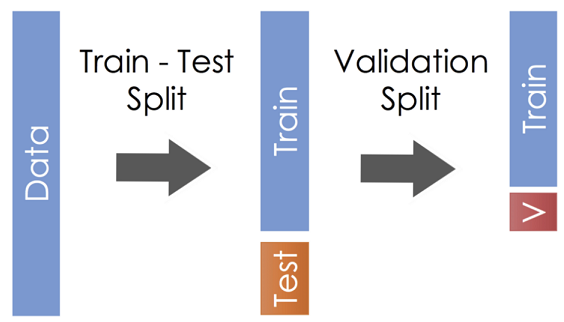

In [258]:
CNN_Word2Vec_model_fit = CNN_Word2Vec_model.fit(
    X_train, y_train, batch_size=256, epochs=15, validation_split=0.1, shuffle=True)

Epoch 1/15
240/240 [==============================] - 261s 1s/step - loss: 0.1141 - accuracy: 0.4393 - recall_m: 0.2692 - precision_m: 0.6718 - f1_m: 0.3709 - jaccard_m: 2.2673 - val_loss: 0.0649 - val_accuracy: 0.5781 - val_recall_m: 0.3978 - val_precision_m: 0.8000 - val_f1_m: 0.5307 - val_jaccard_m: 1.6843
Epoch 2/15
240/240 [==============================] - 259s 1s/step - loss: 0.0625 - accuracy: 0.6051 - recall_m: 0.4537 - precision_m: 0.7783 - f1_m: 0.5723 - jaccard_m: 1.5728 - val_loss: 0.0551 - val_accuracy: 0.6396 - val_recall_m: 0.5119 - val_precision_m: 0.7938 - val_f1_m: 0.6221 - val_jaccard_m: 1.5391
Epoch 3/15
240/240 [==============================] - 259s 1s/step - loss: 0.0565 - accuracy: 0.6441 - recall_m: 0.5115 - precision_m: 0.7874 - f1_m: 0.6197 - jaccard_m: 1.4385 - val_loss: 0.0512 - val_accuracy: 0.6550 - val_recall_m: 0.5239 - val_precision_m: 0.8253 - val_f1_m: 0.6406 - val_jaccard_m: 1.3484
Epoch 4/15
240/240 [==============================] - 261s 1s/step 

In [259]:
CNN_Word2Vec_train_score = CNN_Word2Vec_model.evaluate(
    X_train, y_train, batch_size=256, verbose=1)
print('Train Loss:', CNN_Word2Vec_train_score[0])
print('Train Accuracy:', CNN_Word2Vec_train_score[1])

266/266 [==============================] - 60s 226ms/step - loss: 0.0369 - accuracy: 0.7244 - recall_m: 0.6940 - precision_m: 0.8292 - f1_m: 0.7554 - jaccard_m: 1.0723
Train Loss: 0.036927297711372375
Train Accuracy: 0.7244499325752258


In [260]:
CNN_Word2Vec_test_score = CNN_Word2Vec_model.evaluate(
    X_test, y_test, batch_size=256, verbose=1)
print('Test Loss:', CNN_Word2Vec_test_score[0])
print('Test Accuracy:', CNN_Word2Vec_test_score[1])

67/67 [==============================] - 15s 226ms/step - loss: 0.0429 - accuracy: 0.6948 - recall_m: 0.6540 - precision_m: 0.8017 - f1_m: 0.7201 - jaccard_m: 1.1499
Test Loss: 0.04290641099214554
Test Accuracy: 0.6947888135910034


In [261]:
print('Predicting....')
y_pred = CNN_Word2Vec_model.predict(X_test, batch_size=256, verbose=1)

Predicting....
67/67 [==============================] - 15s 221ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

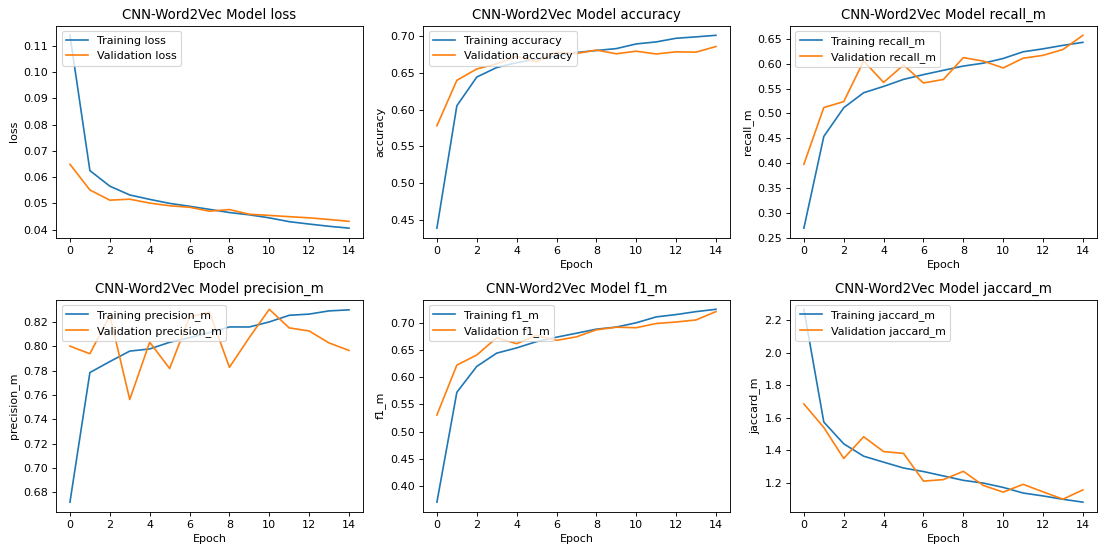

In [262]:
# Plot training & validation performance
fig = plt.figure(figsize=[14, 7], dpi=80)
i = 0
for metric in ['loss', 'accuracy', 'recall_m', 'precision_m', 'f1_m', 'jaccard_m']:
    i += 1
    fig.add_subplot(2, 3, i)
    ax = plt.plot(CNN_Word2Vec_model_fit.history[metric])
    plt.plot(CNN_Word2Vec_model_fit.history['val_'+metric])
    plt.title('CNN-Word2Vec Model ' + metric)
    plt.legend(['Training ' + metric, 'Validation '+metric], loc='upper left')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
plt.tight_layout()
plt.show

In [263]:
y_test_predicted_labels_keras = np.where(y_pred >= 0.5, 1, 0)
y_test_pred_inversed_keras = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_keras)

print("-"*50)
print("Print 10 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_keras[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('c#',), ('python',), ('c#',), ('sql', 'sql-server'), (), ('r',), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [264]:
print("Accuracy :", round(CNN_Word2Vec_test_score[1], 3))
print("Precision :", round(CNN_Word2Vec_test_score[3], 3))
print("Recall :", round(CNN_Word2Vec_test_score[2], 3))
print("F1 :", round(CNN_Word2Vec_test_score[4], 3))
print("Jaccard :", round(CNN_Word2Vec_test_score[5], 3))

Accuracy : 0.695
Precision : 0.802
Recall : 0.654
F1 : 0.72
Jaccard : 1.15


In [265]:
CNN_Word2Vec_test_score[2], CNN_Word2Vec_test_score[3] = CNN_Word2Vec_test_score[3], CNN_Word2Vec_test_score[2]
scores['Word2Vec_CNN'] = CNN_Word2Vec_test_score[1:6]
print(scores['Word2Vec_CNN'])
pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

[0.6947888135910034, 0.8017303943634033, 0.6540082097053528, 0.7200818061828613, 1.1498943567276]


logistic_regression  random_forest       svc       sgd  \
Accuracy              0.395805       0.335292  0.389578  0.341696   
Precision             0.707282       0.799119  0.722331  0.696023   
Recall                0.543127       0.429897  0.523394  0.441447   
F1                    0.600933       0.523460  0.585412  0.516034   
Jaccard               0.452441       0.399928  0.439638  0.390182   

           Word2Vec_CNN  
Accuracy       0.694789  
Precision      0.801730  
Recall         0.654008  
F1             0.720082  
Jaccard        1.149894

##  Word2Vec avec Recurrent Neural Network (RNN)

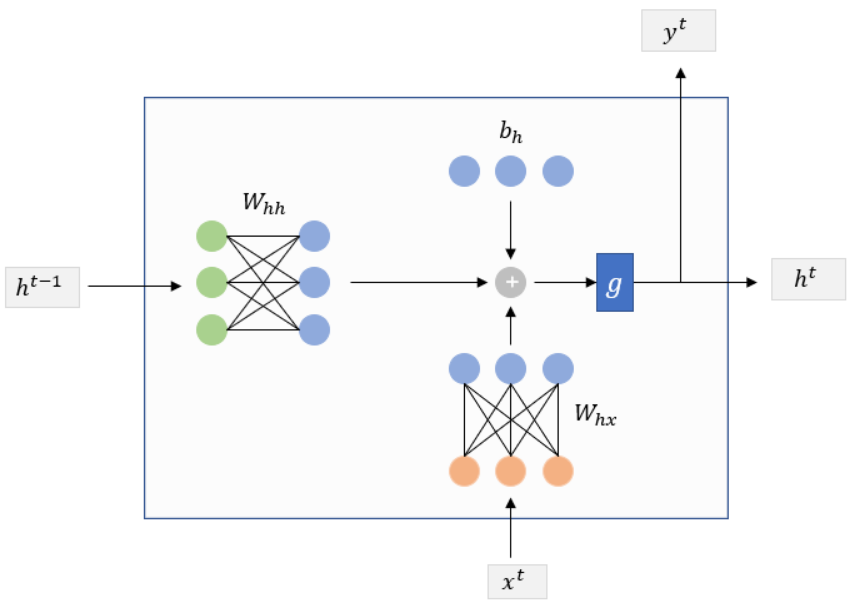

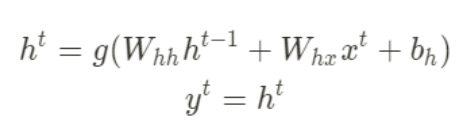

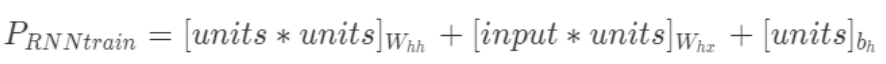

In [266]:
RNN_Word2Vec_model = Sequential([
    Embedding(input_dim=vocab_size, input_length=max_len,
              output_dim=w2v_size, weights=[embedding_matrix], trainable=False),
    # Fully-connected RNN where the output is to be fed back to input.
    SimpleRNN(25, return_sequences=True),
    # **batch normalization layer** normalizes the activations of the previous layer at each batch,
    # i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    BatchNormalization(),
    Dropout(0.1),
    GlobalMaxPool1D(),
    Dense(50, activation='relu'),
    Dense(50, activation='sigmoid')
])

In [267]:
RNN_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision_m, recall_m, f1_m, jaccard_m])

In [268]:
RNN_Word2Vec_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 433, 100)          15426900  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 433, 25)           3150      
                                                                 
 batch_normalization_4 (Batc  (None, 433, 25)          100       
 hNormalization)                                                 
                                                                 
 dropout_43 (Dropout)        (None, 433, 25)           0         
                                                                 
 global_max_pooling1d_4 (Glo  (None, 25)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 50)               

In [269]:
RNN_Word2Vec_model_fit = RNN_Word2Vec_model.fit(
    X_train, y_train, batch_size=256, epochs=15, validation_split=0.1, shuffle=True)

Epoch 1/15
240/240 [==============================] - 200s 831ms/step - loss: 0.1150 - accuracy: 0.2477 - precision_m: 0.4479 - recall_m: 0.0824 - f1_m: 0.1264 - jaccard_m: 2.6452 - val_loss: 0.1016 - val_accuracy: 0.3485 - val_precision_m: 0.8704 - val_recall_m: 0.0810 - val_f1_m: 0.1479 - val_jaccard_m: 2.8365
Epoch 2/15
240/240 [==============================] - 199s 830ms/step - loss: 0.0837 - accuracy: 0.4534 - precision_m: 0.7283 - recall_m: 0.2772 - f1_m: 0.3985 - jaccard_m: 2.0287 - val_loss: 0.0823 - val_accuracy: 0.4739 - val_precision_m: 0.8001 - val_recall_m: 0.2557 - val_f1_m: 0.3872 - val_jaccard_m: 2.2790
Epoch 3/15
240/240 [==============================] - 199s 829ms/step - loss: 0.0779 - accuracy: 0.4994 - precision_m: 0.7562 - recall_m: 0.3305 - f1_m: 0.4584 - jaccard_m: 1.8947 - val_loss: 0.0784 - val_accuracy: 0.5114 - val_precision_m: 0.7594 - val_recall_m: 0.3270 - val_f1_m: 0.4568 - val_jaccard_m: 2.2133
Epoch 4/15
240/240 [==============================] - 200s

In [270]:
RNN_Word2Vec_train_score = RNN_Word2Vec_model.evaluate(
    X_train, y_train, batch_size=256, verbose=1)
print('Train Loss:', RNN_Word2Vec_train_score[0])
print('Train Accuracy:', RNN_Word2Vec_train_score[1])

266/266 [==============================] - 52s 197ms/step - loss: 0.0594 - accuracy: 0.6154 - precision_m: 0.8088 - recall_m: 0.4784 - f1_m: 0.6009 - jaccard_m: 1.6366
Train Loss: 0.05938032269477844
Train Accuracy: 0.6154196262359619


In [271]:
RNN_Word2Vec_test_score = RNN_Word2Vec_model.evaluate(
    X_test, y_test, batch_size=256, verbose=1)
print('Test Loss:', RNN_Word2Vec_test_score[0])
print('Test Accuracy:', RNN_Word2Vec_test_score[1])

67/67 [==============================] - 13s 195ms/step - loss: 0.0606 - accuracy: 0.6068 - precision_m: 0.8048 - recall_m: 0.4708 - f1_m: 0.5936 - jaccard_m: 1.6509
Test Loss: 0.060625117272138596
Test Accuracy: 0.606838583946228


In [272]:
# Predicting......
print('Predicting....')
y_pred = RNN_Word2Vec_model.predict(X_test, batch_size=256, verbose=1)

Predicting....
67/67 [==============================] - 13s 192ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

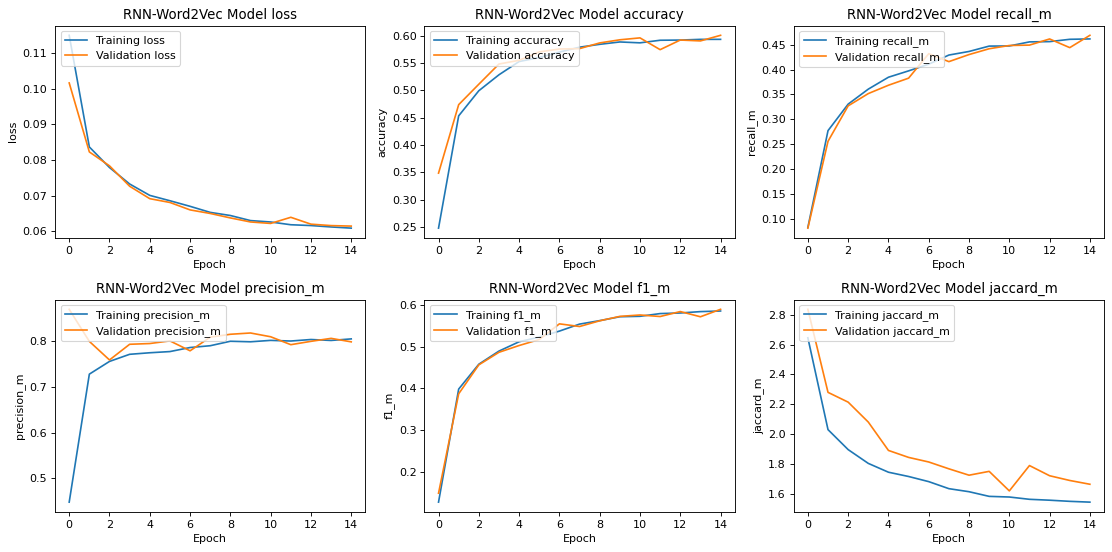

In [273]:
# Plot training & validation performance
fig = plt.figure(figsize=[14, 7], dpi=80)
i = 0
for metric in ['loss', 'accuracy', 'recall_m', 'precision_m', 'f1_m', 'jaccard_m']:
    i += 1
    fig.add_subplot(2, 3, i)
    ax = plt.plot(RNN_Word2Vec_model_fit.history[metric])
    plt.plot(RNN_Word2Vec_model_fit.history['val_'+metric])
    plt.title('RNN-Word2Vec Model ' + metric)
    plt.legend(['Training ' + metric, 'Validation '+metric], loc='upper left')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
plt.tight_layout()
plt.show

In [274]:
y_test_predicted_labels_keras = np.where(y_pred >= 0.5, 1, 0)
y_test_pred_inversed_keras = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_keras)

print("-"*50)
print("Print 10 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_keras[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('mysql',), (), ('python',), ('c#',), ('sql', 'sql-server'), (), ('r',), ('c',), ('c#',), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [275]:
print("Accuracy :", round(RNN_Word2Vec_test_score[1], 3))
print("Precision :", round(RNN_Word2Vec_test_score[2], 3))
print("Recall :", round(RNN_Word2Vec_test_score[3], 3))
print("F1 :", round(RNN_Word2Vec_test_score[4], 3))
print("Jaccard :", round(RNN_Word2Vec_test_score[5], 3))

Accuracy : 0.607
Precision : 0.805
Recall : 0.471
F1 : 0.594
Jaccard : 1.651


In [276]:
scores['Word2Vec_RNN'] = RNN_Word2Vec_test_score[1:6]
print(scores['Word2Vec_RNN'])
pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

[0.606838583946228, 0.8048116564750671, 0.4707866609096527, 0.5935830473899841, 1.6509120464324951]


logistic_regression  random_forest       svc       sgd  \
Accuracy              0.395805       0.335292  0.389578  0.341696   
Precision             0.707282       0.799119  0.722331  0.696023   
Recall                0.543127       0.429897  0.523394  0.441447   
F1                    0.600933       0.523460  0.585412  0.516034   
Jaccard               0.452441       0.399928  0.439638  0.390182   

           Word2Vec_CNN  Word2Vec_RNN  
Accuracy       0.694789      0.606839  
Precision      0.801730      0.804812  
Recall         0.654008      0.470787  
F1             0.720082      0.593583  
Jaccard        1.149894      1.650912

## Word2Vec avec Long Short-Term Memory (LSTM)

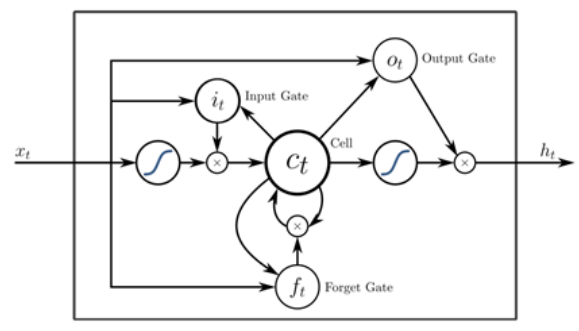

In [277]:
LSTM_Word2Vec_model = Sequential([
    Embedding(input_dim=vocab_size, input_length=max_len,
              output_dim=w2v_size, weights=[embedding_matrix], trainable=False),
    # Bidirectional layer will enable our model to predict a missing word in a sequence,
    # So, using this feature will enable the model to look at the context on both the left and the right.
    LSTM(25, return_sequences=True),
    # **batch normalization layer** normalizes the activations of the previous layer at each batch,
    # i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    BatchNormalization(),
    Dropout(0.1),
    GlobalMaxPool1D(),
    Dense(50, activation='relu'),
    Dense(50, activation='sigmoid')
])

LSTM_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(
    0.01), metrics=['accuracy', precision_m, recall_m, f1_m, jaccard_m])

In [278]:
LSTM_Word2Vec_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 433, 100)          15426900  
                                                                 
 lstm_1 (LSTM)               (None, 433, 25)           12600     
                                                                 
 batch_normalization_5 (Batc  (None, 433, 25)          100       
 hNormalization)                                                 
                                                                 
 dropout_44 (Dropout)        (None, 433, 25)           0         
                                                                 
 global_max_pooling1d_5 (Glo  (None, 25)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 50)               

In [279]:
LSTM_Word2Vec_model_fit = LSTM_Word2Vec_model.fit(
    X_train, y_train, batch_size=256, epochs=10, validation_split=0.1, shuffle=True)

Epoch 1/10
240/240 [==============================] - 382s 2s/step - loss: 0.0957 - accuracy: 0.4258 - precision_m: 0.6410 - recall_m: 0.2472 - f1_m: 0.3417 - jaccard_m: 2.2602 - val_loss: 0.1045 - val_accuracy: 0.5067 - val_precision_m: 0.8718 - val_recall_m: 0.1726 - val_f1_m: 0.2877 - val_jaccard_m: 3.6652
Epoch 2/10
240/240 [==============================] - 381s 2s/step - loss: 0.0580 - accuracy: 0.6269 - precision_m: 0.8074 - recall_m: 0.4941 - f1_m: 0.6120 - jaccard_m: 1.4734 - val_loss: 0.0585 - val_accuracy: 0.6347 - val_precision_m: 0.8729 - val_recall_m: 0.4413 - val_f1_m: 0.5860 - val_jaccard_m: 1.7693
Epoch 3/10
240/240 [==============================] - 386s 2s/step - loss: 0.0517 - accuracy: 0.6524 - precision_m: 0.8128 - recall_m: 0.5475 - f1_m: 0.6538 - jaccard_m: 1.3331 - val_loss: 0.0517 - val_accuracy: 0.6430 - val_precision_m: 0.8215 - val_recall_m: 0.5330 - val_f1_m: 0.6461 - val_jaccard_m: 1.4085
Epoch 4/10
240/240 [==============================] - 381s 2s/step 

In [280]:
# train
LSTM_Word2Vec_train_score = LSTM_Word2Vec_model.evaluate(
    X_train, y_train, batch_size=256, verbose=1)
print('Train Loss:', LSTM_Word2Vec_train_score[0])
print('Train Accuracy:', LSTM_Word2Vec_train_score[1])

# test
LSTM_Word2Vec_test_score = LSTM_Word2Vec_model.evaluate(
    X_test, y_test, batch_size=256, verbose=1)
print('Test Loss:', LSTM_Word2Vec_test_score[0])
print('Test Accuracy:', LSTM_Word2Vec_test_score[1])

266/266 [==============================] - 246s 925ms/step - loss: 0.0429 - accuracy: 0.6928 - precision_m: 0.8258 - recall_m: 0.6332 - f1_m: 0.7165 - jaccard_m: 1.2433
Train Loss: 0.04293334111571312
Train Accuracy: 0.6927822232246399
67/67 [==============================] - 61s 918ms/step - loss: 0.0460 - accuracy: 0.6739 - precision_m: 0.8127 - recall_m: 0.6132 - f1_m: 0.6987 - jaccard_m: 1.2861
Test Loss: 0.045984331518411636
Test Accuracy: 0.6739321947097778


In [281]:
# Predicting......
print('Predicting....')
y_pred = LSTM_Word2Vec_model.predict(X_test, batch_size=256, verbose=1)

Predicting....
67/67 [==============================] - 61s 910ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

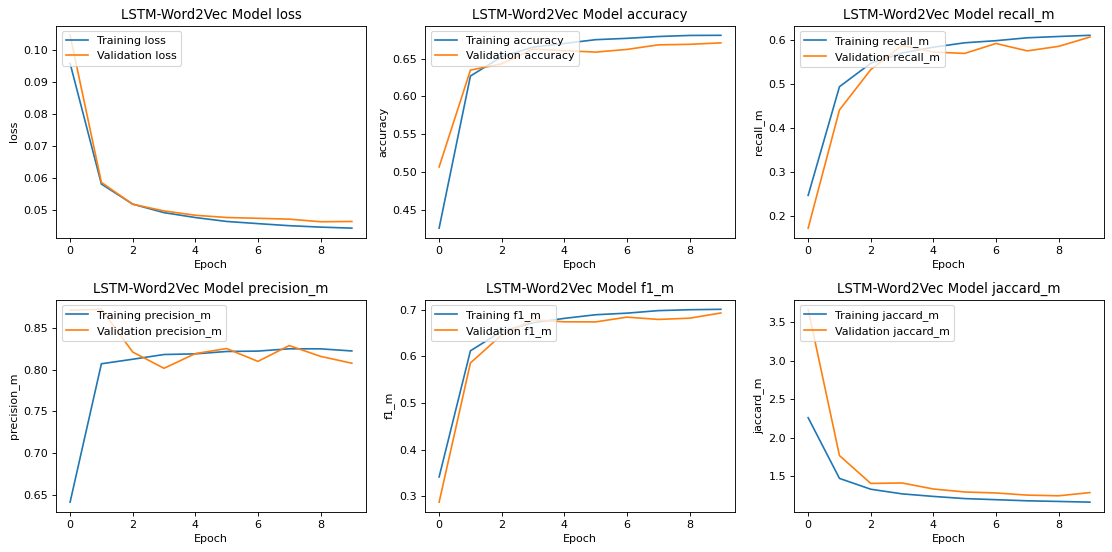

In [282]:
# Plot training & validation performance
fig = plt.figure(figsize=[14, 7], dpi=80)
i = 0
for metric in ['loss', 'accuracy', 'recall_m', 'precision_m', 'f1_m', 'jaccard_m']:
    i += 1
    fig.add_subplot(2, 3, i)
    ax = plt.plot(LSTM_Word2Vec_model_fit.history[metric])
    plt.plot(LSTM_Word2Vec_model_fit.history['val_'+metric])
    plt.title('LSTM-Word2Vec Model ' + metric)
    plt.legend(['Training ' + metric, 'Validation '+metric], loc='upper left')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
plt.tight_layout()
plt.show

In [283]:
y_test_predicted_labels_keras = np.where(y_pred >= 0.5, 1, 0)
y_test_pred_inversed_keras = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_keras)

print("-"*50)
print("Print 10 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_keras[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('mysql',), (), ('macos', 'python'), ('asp.net', 'asp.net-mvc', 'c#'), ('sql',), ('algorithm',), ('r',), ('c', 'gcc'), ('.net', 'c#'), ('java',)]
True: [('mysql', 'sql'), ('c#', 'visual-studio'), ('macos', 'python'), ('.net', 'asp.net', 'asp.net-mvc', 'c#'), ('c#', 'sql'), ('algorithm',), ('performance', 'r'), ('c',), ('c#',), ('java',)]


In [284]:
print("Accuracy :", round(LSTM_Word2Vec_test_score[1], 3))
print("Precision :", round(LSTM_Word2Vec_test_score[2], 3))
print("Recall :", round(LSTM_Word2Vec_test_score[3], 3))
print("F1 :", round(LSTM_Word2Vec_test_score[4], 3))
print("Jaccard :", round(LSTM_Word2Vec_test_score[5], 3))

Accuracy : 0.674
Precision : 0.813
Recall : 0.613
F1 : 0.699
Jaccard : 1.286


In [285]:
scores['Word2Vec_LSTM'] = LSTM_Word2Vec_test_score[1:6]
print(scores['Word2Vec_LSTM'])
pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

[0.6739321947097778, 0.8126835227012634, 0.6131815910339355, 0.698707640171051, 1.286128282546997]


logistic_regression  random_forest       svc       sgd  \
Accuracy              0.395805       0.335292  0.389578  0.341696   
Precision             0.707282       0.799119  0.722331  0.696023   
Recall                0.543127       0.429897  0.523394  0.441447   
F1                    0.600933       0.523460  0.585412  0.516034   
Jaccard               0.452441       0.399928  0.439638  0.390182   

           Word2Vec_CNN  Word2Vec_RNN  Word2Vec_LSTM  
Accuracy       0.694789      0.606839       0.673932  
Precision      0.801730      0.804812       0.812684  
Recall         0.654008      0.470787       0.613182  
F1             0.720082      0.593583       0.698708  
Jaccard        1.149894      1.650912       1.286128

## Approches word embeddings: BERT 

In [286]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from transformers import BertTokenizer, BertModel, TFAutoModel, AutoTokenizer, TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import time
from tqdm.notebook import tqdm

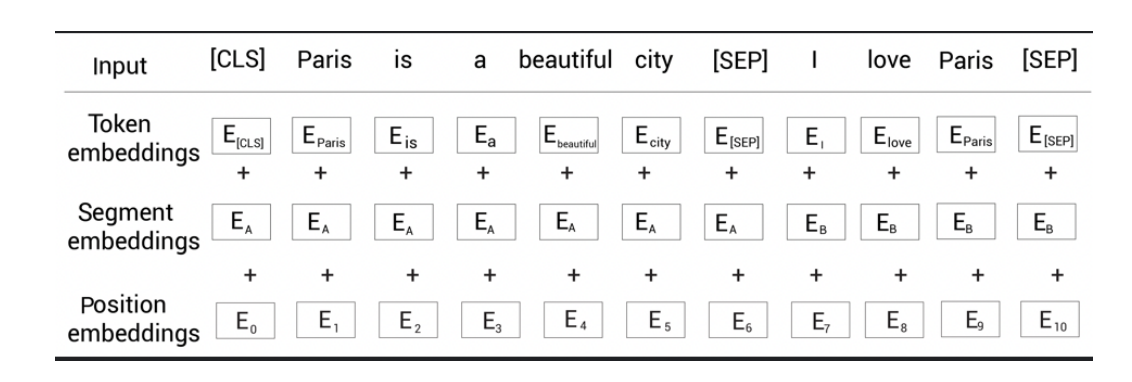

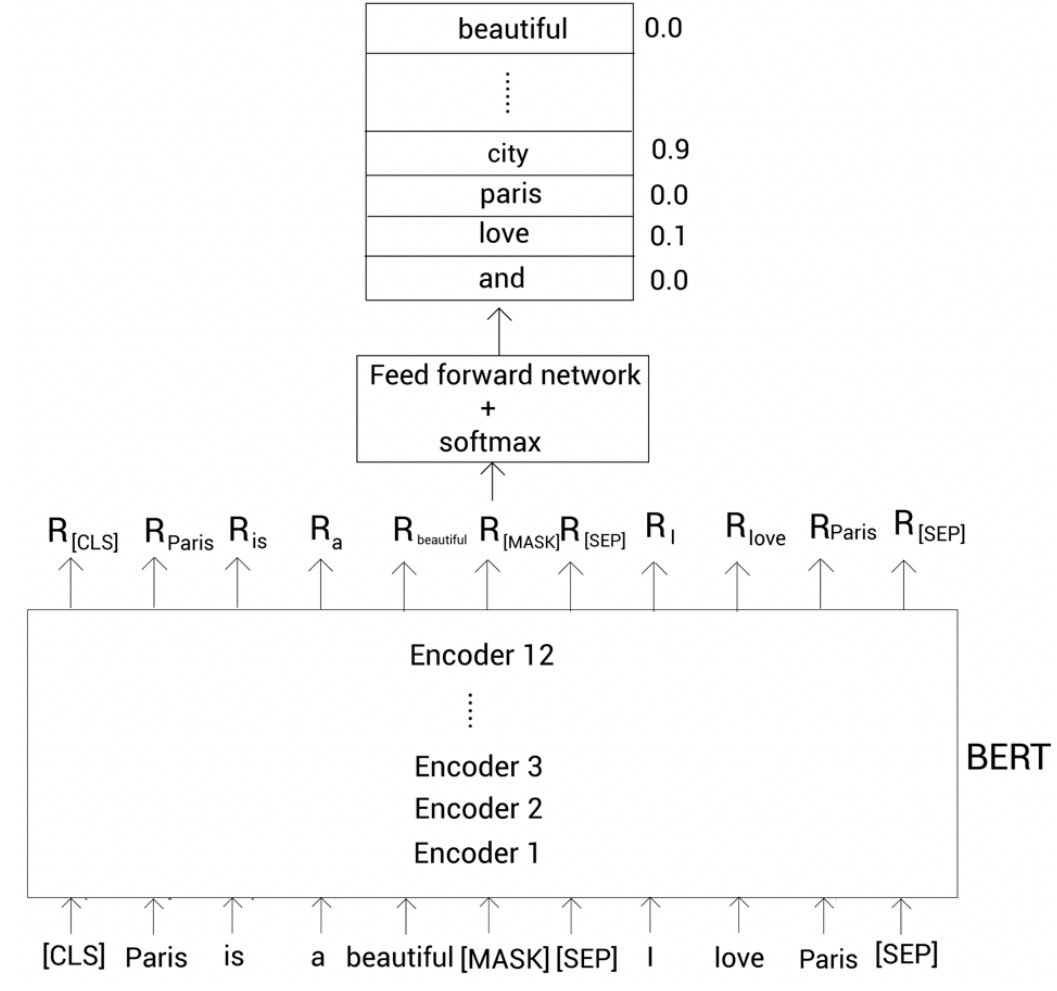

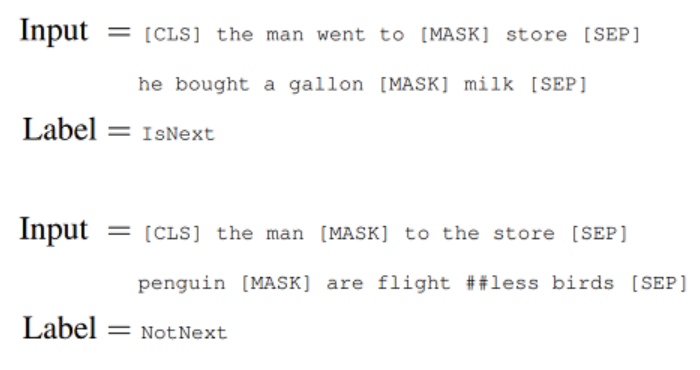

In [287]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf"
                                              )

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [288]:
# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in tqdm(range(len(sentences)//batch_size)):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                               bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred, verbose=False)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

In [289]:
data.head()

Text  \
Id                                                           
5004633  [file, dot, prefix, windows, example, htaccess...   
5004344  [prevent, opera, browser, html, fieldsi, load,...   
5004908  [format, image, file, image, format, image, fi...   
5004837  [class, static, method, class, variable, pytho...   
5005409  [exception, resolve, assemblies, executable, f...   

                               Tags  
Id                                   
5004633                   [windows]  
5004344  [javascript, jquery, html]  
5004908                        [c#]  
5004837                    [python]  
5005409                        [c#]

In [290]:
data_bert = data.reset_index()
data_bert = data_bert[data_bert.index < 10000]

In [291]:
data_bert.shape

(10000, 3)

In [292]:
data_bert.head()

Id                                               Text  \
0  5004633  [file, dot, prefix, windows, example, htaccess...   
1  5004344  [prevent, opera, browser, html, fieldsi, load,...   
2  5004908  [format, image, file, image, format, image, fi...   
3  5004837  [class, static, method, class, variable, pytho...   
4  5005409  [exception, resolve, assemblies, executable, f...   

                         Tags  
0                   [windows]  
1  [javascript, jquery, html]  
2                        [c#]  
3                    [python]  
4                        [c#]

In [293]:
max_len = 0
for i in data_bert['Text']:
    if len(i) > max_len:
        max_len = len(i)
        max_ind = i
print(max_len)

358


In [294]:
data_bert['Text1'] = data_bert['Text'].apply(lambda x: ' '.join(x))
data_bert.head()

Id                                               Text  \
0  5004633  [file, dot, prefix, windows, example, htaccess...   
1  5004344  [prevent, opera, browser, html, fieldsi, load,...   
2  5004908  [format, image, file, image, format, image, fi...   
3  5004837  [class, static, method, class, variable, pytho...   
4  5005409  [exception, resolve, assemblies, executable, f...   

                         Tags  \
0                   [windows]   
1  [javascript, jquery, html]   
2                        [c#]   
3                    [python]   
4                        [c#]   

                                               Text1  
0  file dot prefix windows example htaccessi file...  
1  prevent opera browser html fieldsi load input ...  
2  format image file image format image file enco...  
3  class static method class variable pythoni ima...  
4  exception resolve assemblies executable fixups...

In [295]:
X = data_bert['Text1']

In [296]:
y = data_bert['Tags']

In [297]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data_bert['Tags'])
multilabel_binarizer.classes_
y = multilabel_binarizer.transform(data_bert['Tags'])
y.shape

(10000, 46)

In [298]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)
print("X_train dimension: ", X_train.shape)
print("y_train dimension: ", y_train.shape)
print("X_test dimension: ", X_test.shape)
print("y_test dimension: ", y_test.shape)

X_train dimension:  (8000,)
y_train dimension:  (8000, 46)
X_test dimension:  (2000,)
y_test dimension:  (2000, 46)


In [299]:
print(X_train[:2])

9254    expressioni languages ruby cofeescript transco...
1561    shoot event subscriptioni order shoot subscrip...
Name: Text1, dtype: object


In [300]:
y_train.shape

(8000, 46)

In [301]:
print(len(y_train[:]))

8000


In [303]:
y_train.shape

(8000, 46)

### Feature engineering pour X_train 

In [304]:
X_train = X_train.values

In [305]:
print(X_train[:2])

['expressioni languages ruby cofeescript transcompiler expression language surface publications positives negative approach publications examples benefit expression examples coffeescript javascript concept idea opinion thank'
 'shoot event subscriptioni order shoot subscription events self pattern eventhandler handler null handler sender someevent handler initialize someevent handler lot boiler plate resharper whinge closure way pattern extension method way someevent']


In [306]:
max_length = max_len
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [307]:
X_train_features_bert = feature_BERT_fct(
    model, model_type, X_train, max_len, batch_size, mode='HF')

  0%|          | 0/800 [00:00<?, ?it/s]

temps traitement :  16469.0


In [308]:
print(X_train_features_bert[0][2])

[-9.39718485e-02 -3.23076658e-02  2.09514916e-01 -4.22389396e-02  7.26572704e-03  1.48210838e-01 -2.09559146e-02 -3.21935341e-02
  7.28662238e-02 -5.90784140e-02 -1.72733188e-01  1.08360827e-01 -1.80777952e-01  9.80023965e-02  1.32191870e-02  1.47197634e-01
 -3.03711593e-01  8.00394416e-02  6.79069534e-02  1.49587274e-01  1.97566479e-01 -1.82250246e-01 -1.25521436e-01 -1.59162313e-01
  3.24233741e-01 -7.91295394e-02 -4.18512106e-01 -2.25211024e-01 -4.25348252e-01  1.37849122e-01 -1.98631525e-01 -1.81251824e-01
  5.45973182e-02 -1.17740132e-01 -2.89133906e-01 -1.60233021e-01 -3.53609622e-02 -8.57729763e-02  6.94009736e-02 -4.73000258e-02
 -1.62584201e-01 -5.81379235e-01  3.91278148e-01  7.86649361e-02  6.97945952e-02 -2.95260362e-02 -4.74219769e-01 -3.06903273e-01
 -1.95960894e-01 -1.19540229e-01 -4.73621637e-01  4.01325524e-02 -1.34676680e-01  1.55209020e-01  7.15445057e-02 -1.55658260e-01
  1.01763614e-01 -4.77873534e-01  2.41065044e-02 -7.99242333e-02  1.25156522e-01 -1.76103294e-01 

In [309]:
X_train_features_bert[0].shape

(8000, 768)

In [310]:
print(X_train[1])

shoot event subscriptioni order shoot subscription events self pattern eventhandler handler null handler sender someevent handler initialize someevent handler lot boiler plate resharper whinge closure way pattern extension method way someevent


In [311]:
bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
print(bert_tokenizer.encode_plus(X_train[1],
                                 add_special_tokens=True,
                                 max_length=max_length,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 return_token_type_ids=True,
                                 truncation=True,
                                 return_tensors="tf"
                                 ))

{'input_ids': <tf.Tensor: shape=(1, 358), dtype=int32, numpy=
array([[  101,  5607,  2724, 15002,  2072,  2344,  5607, 15002,  2824,  2969,  5418,  2724, 11774,  3917, 28213, 19701, 28213,  4604,
         2121,  2070, 18697,  3372, 28213,  3988,  4697,  2070, 18697,  3372, 28213,  2843, 15635,  5127, 24501,  8167,  4842,  1059,
        12053,  2063,  8503,  2126,  5418,  5331,  4118,  2126,  2070, 18697,  3372,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


### Feature engineering pour X_test 

In [312]:
X_test = X_test.values

In [313]:
X_test_features_bert = feature_BERT_fct(
    model, model_type, X_test, max_len, batch_size, mode='HF')

  0%|          | 0/200 [00:00<?, ?it/s]

temps traitement :  3483.0


In [314]:
X_test_features_bert[0].shape

(2000, 768)

### Création du modèle avec Bert 

In [315]:
Bert_model = Sequential()
Bert_model.add(tf.keras.Input(shape=(768,)))
Bert_model.add(tf.keras.layers.Dense(512, activation='relu'))
Bert_model.add(tf.keras.layers.Dropout(rate=0.4))
Bert_model.add(tf.keras.layers.Dense(46, activation='sigmoid'))

Bert_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
                   'accuracy', precision_m, recall_m, f1_m, jaccard_m])

Bert_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               393728    
                                                                 
 dropout_82 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 46)                23598     
                                                                 
Total params: 417,326
Trainable params: 417,326
Non-trainable params: 0
_________________________________________________________________


In [316]:
Bert_model_fit = Bert_model.fit(
    X_train_features_bert[0][:], y_train, epochs=40, batch_size=128, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/40
57/57 [==============================] - 3s 40ms/step - loss: 0.1810 - accuracy: 0.1112 - precision_m: 0.2557 - recall_m: 0.0345 - f1_m: 0.0340 - jaccard_m: 4.0170 - val_loss: 0.1134 - val_accuracy: 0.2138 - val_precision_m: 0.5952 - val_recall_m: 0.0093 - val_f1_m: 0.0182 - val_jaccard_m: 2.4198
Epoch 2/40
57/57 [==============================] - 2s 37ms/step - loss: 0.1140 - accuracy: 0.2342 - precision_m: 0.5381 - recall_m: 0.0437 - f1_m: 0.0798 - jaccard_m: 2.5533 - val_loss: 0.1037 - val_accuracy: 0.2650 - val_precision_m: 0.7577 - val_recall_m: 0.0370 - val_f1_m: 0.0700 - val_jaccard_m: 2.3845
Epoch 3/40
57/57 [==============================] - 2s 37ms/step - loss: 0.1042 - accuracy: 0.3001 - precision_m: 0.6357 - recall_m: 0.0793 - f1_m: 0.1400 - jaccard_m: 2.4232 - val_loss: 0.0974 - val_accuracy: 0.3275 - val_precision_m: 0.7004 - val_recall_m: 0.0727 - val_f1_m: 0.1309 - val_jaccard_m: 2.2429
Epoch 4/40
57/57 [==============================] - 2s 37ms/step - loss: 

In [317]:
Bert_model_train_score = Bert_model.evaluate(
    X_train_features_bert[0][:], y_train, batch_size=256, verbose=1)
print('Train Loss:', Bert_model_train_score[0])
print('Train Accuracy:', Bert_model_train_score[1])

32/32 [==============================] - 1s 33ms/step - loss: 0.0535 - accuracy: 0.5905 - precision_m: 0.8561 - recall_m: 0.4476 - f1_m: 0.5872 - jaccard_m: 1.3902
Train Loss: 0.05348490551114082
Train Accuracy: 0.590499997138977


In [318]:
Bert_model_test_score = Bert_model.evaluate(
    X_test_features_bert[0][:], y_test, batch_size=256, verbose=1)
print('Test Loss:', Bert_model_test_score[0])
print('Test Accuracy:', Bert_model_test_score[1])

8/8 [==============================] - 0s 34ms/step - loss: 0.0746 - accuracy: 0.4810 - precision_m: 0.7526 - recall_m: 0.3394 - f1_m: 0.4673 - jaccard_m: 1.6074
Test Loss: 0.07460586726665497
Test Accuracy: 0.48100000619888306


In [319]:
# Predicting......
print('Predicting....')
y_pred = Bert_model.predict(
    X_test_features_bert[0][:], batch_size=256, verbose=1)

Predicting....
8/8 [==============================] - 0s 32ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

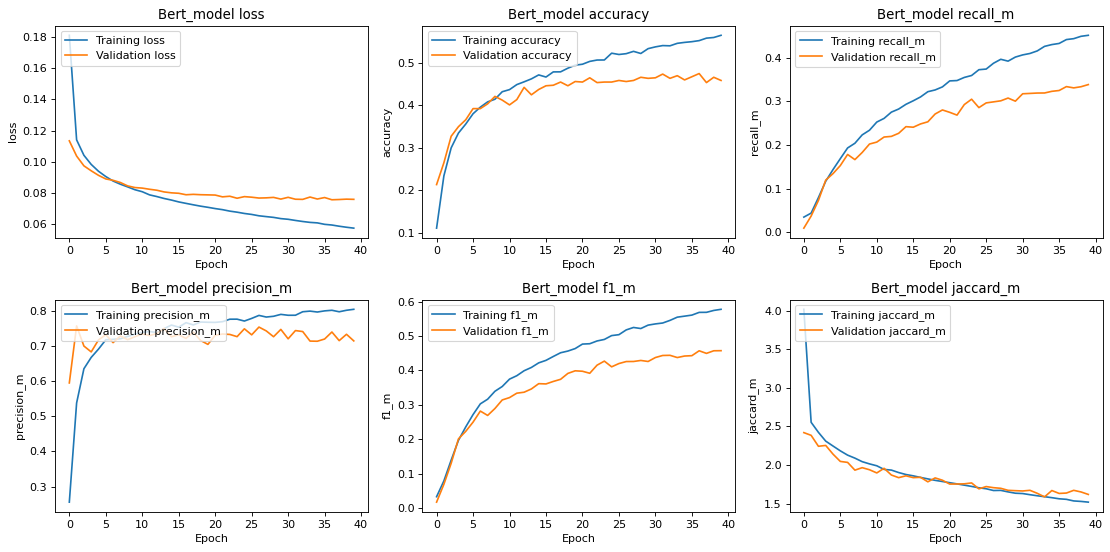

In [320]:
# Plot training & validation performance
fig = plt.figure(figsize=[14, 7], dpi=80)
i = 0
for metric in ['loss', 'accuracy', 'recall_m', 'precision_m', 'f1_m', 'jaccard_m']:
    i += 1
    fig.add_subplot(2, 3, i)
    ax = plt.plot(Bert_model_fit.history[metric])
    plt.plot(Bert_model_fit.history['val_'+metric])
    plt.title('Bert_model ' + metric)
    plt.legend(['Training ' + metric, 'Validation '+metric], loc='upper left')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
plt.tight_layout()
plt.show

In [321]:
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

In [322]:
y_test_predicted_labels_keras = np.where(y_pred >= 0.5, 1, 0)
y_test_pred_inversed_keras = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_keras)
print("-"*50)
print("Print 10 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_keras[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), (), ('c#',), ('android',), ('c++',), (), (), (), ('c#',), ()]
True: [('.net', 'android'), ('sql', 'sql-server'), ('c#',), ('android',), ('c++',), ('windows',), ('css',), ('javascript',), ('sql',), ('c', 'gcc')]


In [323]:
print("Accuracy :", round(Bert_model_test_score[1], 3))
print("Precision :", round(Bert_model_test_score[2], 3))
print("Recall :", round(Bert_model_test_score[3], 3))
print("F1 :", round(Bert_model_test_score[4], 3))
print("Jaccard :", round(Bert_model_test_score[5], 3))

Accuracy : 0.481
Precision : 0.753
Recall : 0.339
F1 : 0.467
Jaccard : 1.607


In [324]:
scores['Bert_NN'] = Bert_model_test_score[1:6]
print(scores['Bert_NN'])
pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

[0.48100000619888306, 0.7525798678398132, 0.33935418725013733, 0.4672911465167999, 1.6073641777038574]


logistic_regression  random_forest       svc       sgd  \
Accuracy              0.395805       0.335292  0.389578  0.341696   
Precision             0.707282       0.799119  0.722331  0.696023   
Recall                0.543127       0.429897  0.523394  0.441447   
F1                    0.600933       0.523460  0.585412  0.516034   
Jaccard               0.452441       0.399928  0.439638  0.390182   

           Word2Vec_CNN  Word2Vec_RNN  Word2Vec_LSTM   Bert_NN  
Accuracy       0.694789      0.606839       0.673932  0.481000  
Precision      0.801730      0.804812       0.812684  0.752580  
Recall         0.654008      0.470787       0.613182  0.339354  
F1             0.720082      0.593583       0.698708  0.467291  
Jaccard        1.149894      1.650912       1.286128  1.607364

## Approches word embeddings: USE 

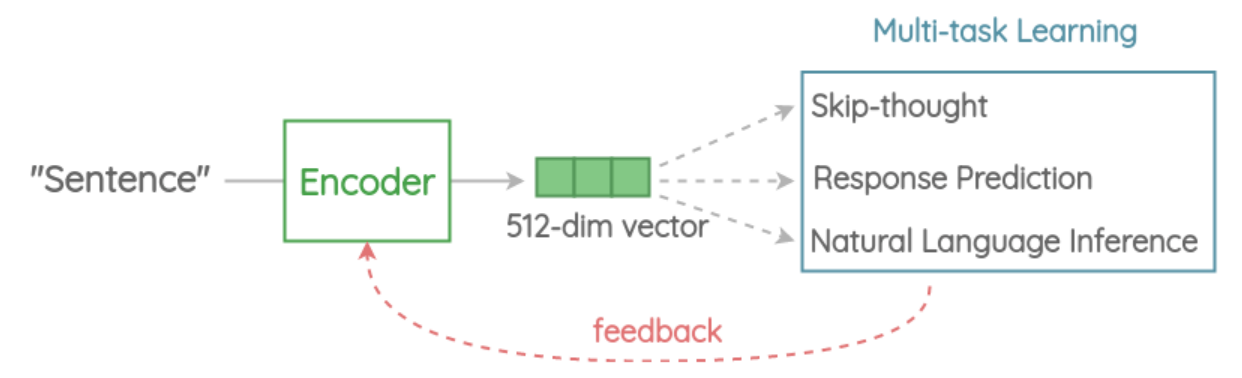

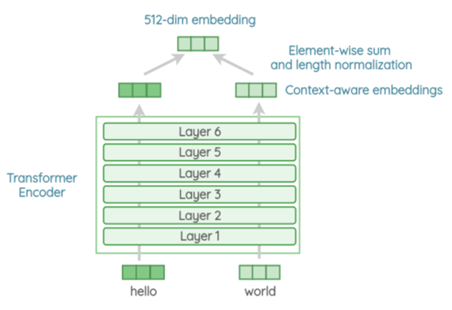

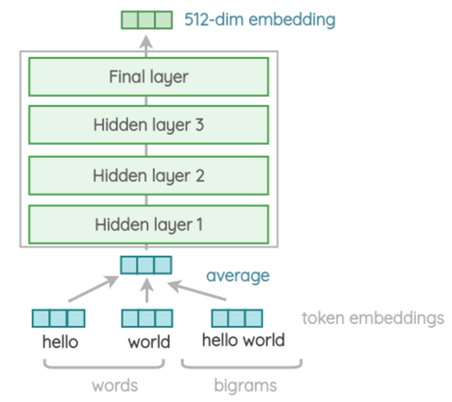

In [325]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from transformers import BertTokenizer, BertModel, TFAutoModel, AutoTokenizer, TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import time
from tqdm.notebook import tqdm

In [326]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [327]:
# Fonction de préparation des sentences
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()
    for step in tqdm(range(len(sentences)//batch_size)):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    return features

In [328]:
data_USE = data.reset_index()
data_USE = data_USE[data_USE.index < 50000]

In [329]:
data_USE['Text1'] = data_USE['Text'].apply(lambda x: ' '.join(x))
data_USE.head()

Id                                               Text  \
0  5004633  [file, dot, prefix, windows, example, htaccess...   
1  5004344  [prevent, opera, browser, html, fieldsi, load,...   
2  5004908  [format, image, file, image, format, image, fi...   
3  5004837  [class, static, method, class, variable, pytho...   
4  5005409  [exception, resolve, assemblies, executable, f...   

                         Tags  \
0                   [windows]   
1  [javascript, jquery, html]   
2                        [c#]   
3                    [python]   
4                        [c#]   

                                               Text1  
0  file dot prefix windows example htaccessi file...  
1  prevent opera browser html fieldsi load input ...  
2  format image file image format image file enco...  
3  class static method class variable pythoni ima...  
4  exception resolve assemblies executable fixups...

In [330]:
X = data_USE['Text1']

In [331]:
y = data_USE['Tags']
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data_USE['Tags'])
multilabel_binarizer.classes_
y = multilabel_binarizer.transform(data_USE['Tags'])
y.shape

(50000, 50)

In [332]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)
print("X_train dimension,X_train, X_test: ", X_train.shape)
print("y_train dimension: ", y_train.shape)
print("X_test dimension: ", X_test.shape)
print("y_test dimension: ", y_test.shape)

X_train dimension,X_train, X_test:  (40000,)
y_train dimension:  (40000, 50)
X_test dimension:  (10000,)
y_test dimension:  (10000, 50)


### Feature engineering pour X_train 

In [333]:
X_train = X_train.values
batch_size = 10
X_train_features_USE = feature_USE_fct(X_train, batch_size)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [334]:
X_train_features_USE.shape

(40000, 512)

### Feature engineering pour X_test 

In [335]:
X_test = X_test.values
X_test_features_USE = feature_USE_fct(X_test, batch_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Création du modèle avec USE 

In [336]:
USE_model = Sequential()
USE_model.add(tf.keras.Input(shape=(512,)))
USE_model.add(tf.keras.layers.Dense(512, activation='relu'))
USE_model.add(tf.keras.layers.Dropout(rate=0.4))
USE_model.add(tf.keras.layers.Dense(50, activation='sigmoid'))

USE_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', precision_m, recall_m, f1_m, jaccard_m])

USE_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dropout_83 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 50)                25650     
                                                                 
Total params: 288,306
Trainable params: 288,306
Non-trainable params: 0
_________________________________________________________________


In [337]:
USE_model_fit = USE_model.fit(X_train_features_USE, y_train, epochs=40,
                              batch_size=128, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/40
282/282 [==============================] - 24s 83ms/step - loss: 0.1273 - accuracy: 0.3827 - precision_m: 0.6130 - recall_m: 0.1499 - f1_m: 0.2199 - jaccard_m: 3.5012 - val_loss: 0.0642 - val_accuracy: 0.5870 - val_precision_m: 0.8341 - val_recall_m: 0.3740 - val_f1_m: 0.5153 - val_jaccard_m: 1.7717
Epoch 2/40
282/282 [==============================] - 23s 81ms/step - loss: 0.0587 - accuracy: 0.6111 - precision_m: 0.8029 - recall_m: 0.4426 - f1_m: 0.5689 - jaccard_m: 1.6291 - val_loss: 0.0513 - val_accuracy: 0.6405 - val_precision_m: 0.8214 - val_recall_m: 0.4989 - val_f1_m: 0.6200 - val_jaccard_m: 1.4343
Epoch 3/40
282/282 [==============================] - 23s 81ms/step - loss: 0.0512 - accuracy: 0.6410 - precision_m: 0.8065 - recall_m: 0.5222 - f1_m: 0.6332 - jaccard_m: 1.4225 - val_loss: 0.0478 - val_accuracy: 0.6532 - val_precision_m: 0.8166 - val_recall_m: 0.5416 - val_f1_m: 0.6506 - val_jaccard_m: 1.3057
Epoch 4/40
282/282 [==============================] - 23s 81ms/s

In [338]:
USE_model_train_score = USE_model.evaluate(
    X_train_features_USE, y_train, batch_size=256, verbose=1)
print('Train Loss:', USE_model_train_score[0])
print('Train Accuracy:', USE_model_train_score[1])

157/157 [==============================] - 13s 82ms/step - loss: 0.0288 - accuracy: 0.7287 - precision_m: 0.8841 - recall_m: 0.7290 - f1_m: 0.7989 - jaccard_m: 0.8464
Train Loss: 0.028792910277843475
Train Accuracy: 0.7286999821662903


In [339]:
USE_model_test_score = USE_model.evaluate(
    X_test_features_USE, y_test, batch_size=256, verbose=1)
print('Test Loss:', USE_model_test_score[0])
print('Test Accuracy:', USE_model_test_score[1])

40/40 [==============================] - 3s 82ms/step - loss: 0.0428 - accuracy: 0.6744 - precision_m: 0.8063 - recall_m: 0.6450 - f1_m: 0.7163 - jaccard_m: 1.0156
Test Loss: 0.042794644832611084
Test Accuracy: 0.6743999719619751


In [340]:
# Predicting......
print('Predicting....')
y_pred = USE_model.predict(X_test_features_USE, batch_size=256, verbose=1)

Predicting....
40/40 [==============================] - 3s 80ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

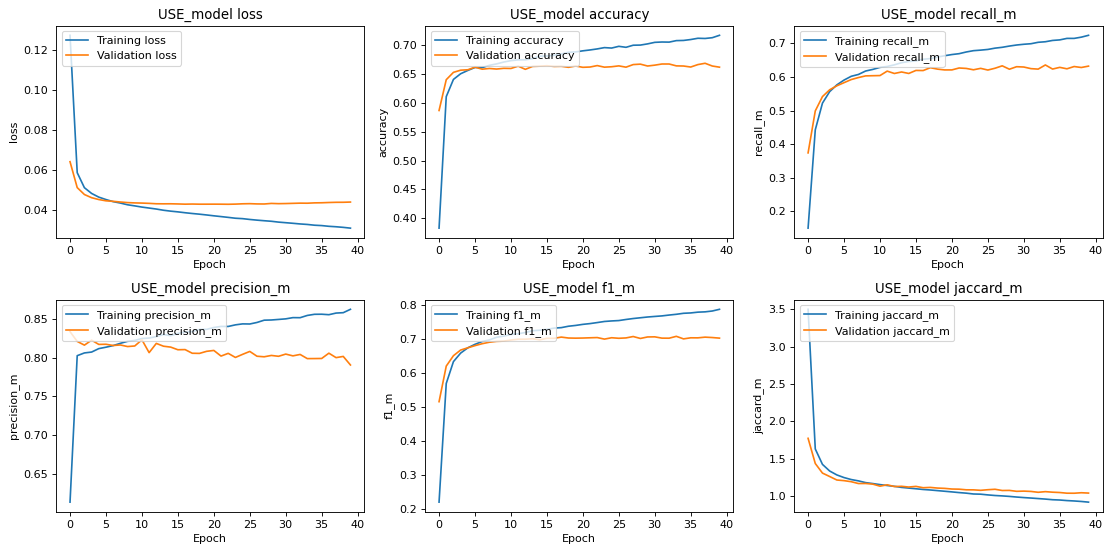

In [341]:
# Plot training & validation performance
fig = plt.figure(figsize=[14, 7], dpi=80)
i = 0
for metric in ['loss', 'accuracy', 'recall_m', 'precision_m', 'f1_m', 'jaccard_m']:
    i += 1
    fig.add_subplot(2, 3, i)
    ax = plt.plot(USE_model_fit.history[metric])
    plt.plot(USE_model_fit.history['val_'+metric])
    plt.title('USE_model ' + metric)
    plt.legend(['Training ' + metric, 'Validation '+metric], loc='upper left')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
plt.tight_layout()
plt.show

In [343]:
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

In [344]:
y_test_predicted_labels_keras = np.where(y_pred >= 0.5, 1, 0)
y_test_pred_inversed_keras = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_keras)

print("-"*50)
print("Print 10 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_keras[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('java',), ('sql',), ('javascript',), ('java',), ('java',), ('c++', 'c++11'), ('c++',), ('python',), ('python',), ('algorithm',)]
True: [('java',), ('sql',), ('javascript',), ('java', 'performance'), ('java',), ('c++11',), ('c++',), ('python',), ('python',), ('python', 'python-3.x')]


In [345]:
print("Accuracy :", round(USE_model_test_score[1], 3))
print("Precision :", round(USE_model_test_score[2], 3))
print("Recall :", round(USE_model_test_score[3], 3))
print("F1 :", round(USE_model_test_score[4], 3))
print("Jaccard :", round(USE_model_test_score[5], 3))

Accuracy : 0.674
Precision : 0.806
Recall : 0.645
F1 : 0.716
Jaccard : 1.016


In [346]:
scores['USE_NN'] = USE_model_test_score[1:6]
print(scores['USE_NN'])
pd.DataFrame(scores, index=['Accuracy',
             'Precision', 'Recall', 'F1', 'Jaccard'])

[0.6743999719619751, 0.8063148260116577, 0.6449786424636841, 0.716334342956543, 1.0156017541885376]


logistic_regression  random_forest       svc       sgd  \
Accuracy              0.395805       0.335292  0.389578  0.341696   
Precision             0.707282       0.799119  0.722331  0.696023   
Recall                0.543127       0.429897  0.523394  0.441447   
F1                    0.600933       0.523460  0.585412  0.516034   
Jaccard               0.452441       0.399928  0.439638  0.390182   

           Word2Vec_CNN  Word2Vec_RNN  Word2Vec_LSTM   Bert_NN    USE_NN  
Accuracy       0.694789      0.606839       0.673932  0.481000  0.674400  
Precision      0.801730      0.804812       0.812684  0.752580  0.806315  
Recall         0.654008      0.470787       0.613182  0.339354  0.644979  
F1             0.720082      0.593583       0.698708  0.467291  0.716334  
Jaccard        1.149894      1.650912       1.286128  1.607364  1.015602

In [347]:
joblib.dump(log_reg_clf, 'log_ref_clf.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(multilabel_binarizer, 'multilabel_binarizer.pkl')

['multilabel_binarizer.pkl']